# 14. Agrupamento e Análise - Algortimos Não Supervisionados

In [ ]:
gold_path = "C:/Users/Gustavo/Downloads/datamaster/dados/gold/"

## 14.1. Propostas de agrupamento

### 14.1.1. Proposta 1: Análise de Volatilidade e Incerteza

**Premissa**: Agrupar clientes não pelo que demonstram hoje, mas olhando como o comportamento destes oscila ao longo do tempo.

* Valor de Negócio: Um cliente que gasta 50 NTD todo mês é diferente de um que gasta 100 NTD em um mês e 0 NTD no outro. O segundo perfil é o "Incerto", contrário do "Consistente". Se incerteza é risco, é importante identificar esses casos;
* Granularidade do Dataframe: id do cliente (`msno`) agregado. Calcular o desvio padrão ou coeficiente de variação das features de uso, margem, e transações ao longo de 3/6/12 meses;
* Ideia de análise: Criar clusters de "Consistentes", "Incertos" e "Declíneo".

### 14.1.2. Proposta 2: Segmentação de Valor e Engajamento

**Premissa**: Criar um "mapa de calor" dos clientes, baseando-me em quanto eles usam (engajamento) vs. quanto eles rendem (margem líquida no mês referência).

* Valor de negócio previsto: Identificação dos clientes "VIPs" (alta margem, alto uso), "Eficientes" (alta margem, baixo uso - baixo custo operacional), "Drenos" (baixo lucro, mas usam muito a plataforma) e "Ausentes" (baixo lucro, baixo uso da plataforma);
* Granularidade do Dataframe: id do cliente (`msno`) + `safra`;
* Manter target nula: se o cara tem target nula em M+1, ele é um **churn**. Agrupar esses caras permite ver se existe um "perfil pré-churn" (curiosamente, a premissa do outro modelo preditivo);
* Ideia de análise: Comparar a proporção de churn (target nula) em cada cluster. Se o Cluster X tem 80% de target nula, descobrimos um "grupo de risco".

### 14.1.3. Proposta 3: Diagnóstico de Erros (Auditoria) do Modelo Finalista - LightGBM

**Premissa**: Pegar os n% de clientes onde o LightGBM mais errou (maiores resíduos) e clusterizar esses casos.

* Valor de Negócio: Identificar e explicar para para _stakeholders_ não só a força mas também a fraqueza do modelo: "O modelo executa boas predições para o público X, exceto para o Grupo Y (ex: clientes muito jovens que acabaram de assinar), onde se mostra necessário uma abordagem diferente";
* Granularidade do Dataframe: id do cliente (`msno`) + `safra` + `residual_lgbm`;
* Ideia de análise: Descobrir se o erro é aleatório ou se existe um "perfil de cliente" que a abordagem supervisionada escolhida (rentabilidade) é incapaz de captar.

## 14.2. Estudo de melhor algoritmo para a solução não supervisionada (agrupamento)

Depois de pesquisar e estudar sobre, separei e listei os algoritmos de agrupamento em diferentes famílias:

### **FAMÍLIA 1: PARTICIONAMENTO (Partition-Based)**

#### 1.1 K-Means

**O que faz:** Divide os dados em `k` clusters minimizando a distância intra-cluster (soma dos quadrados das distâncias ao centróide).

**Vantagens:**
- ✅ Extremamente rápido e escalável
- ✅ Simples de interpretar (centróides são "perfis médios")
- ✅ Funciona bem em dados numéricos padronizados
- ✅ Implementação madura (sklearn, pyspark.ml)

**Desvantagens:**
- ❌ Assume clusters esféricos (distância Euclidiana)
- ❌ Sensível a outliers (um outlier puxa o centróide)
- ❌ Precisa definir `k` a priori
- ❌ Não lida bem com clusters de tamanhos/densidades muito diferentes

**Melhor para:**
- ✅ **A) Descoberta dos Perfis** (principal)
- ✅ **D) Jornada do Cliente** (rápido para rodar em múltiplas safras)

**Quando NÃO usar:** Se você tem muitos outliers ou clusters com formatos não-esféricos.

---

#### 1.2 MiniBatch K-Means

**O que faz:** Versão do K-Means que usa mini-batches (amostras aleatórias) para atualizar os centróides, ao invés de processar todos os dados de uma vez.

**Vantagens:**
- ✅ **Muito mais rápido** que K-Means tradicional (10-100x)
- ✅ Escala para milhões de linhas
- ✅ Mesma interpretabilidade do K-Means

**Desvantagens:**
- ❌ Ligeiramente menos preciso que K-Means (mas a diferença é mínima)
- ❌ Mesmas limitações do K-Means (outliers, forma esférica)

**Melhor para:**
- ✅ **A) Descoberta dos Perfis** (quando você tem milhões de linhas)
- ✅ **D) Jornada do Cliente**

**Quando usar:** Sempre que você tiver mais de 500k linhas e quiser velocidade.

---

#### 1.3 K-Medoids (PAM - Partitioning Around Medoids)

**O que faz:** Similar ao K-Means, mas usa **medoids** (pontos reais do dataset) ao invés de centróides (médias). Minimiza a soma das dissimilaridades.

**Vantagens:**
- ✅ **Robusto a outliers** (medoid é um ponto real, não uma média)
- ✅ Funciona com qualquer métrica de distância (não só Euclidiana)
- ✅ Mais interpretável que K-Means (o medoid é um cliente real)

**Desvantagens:**
- ❌ **Muito mais lento** que K-Means (O(n²) vs O(n))
- ❌ Não escala bem para grandes datasets
- ❌ Implementações menos maduras

**Melhor para:**
- ✅ **A) Descoberta dos Perfis** (quando você tem outliers e quer robustez)

**Quando usar:** Datasets pequenos (<100k linhas) com outliers.

---

#### 1.4 K-Prototypes

**O que faz:** Extensão do K-Means para dados **mistos** (numéricos + categóricos). Usa distância Euclidiana para numéricos e "matching dissimilarity" para categóricos.

**Vantagens:**
- ✅ Lida nativamente com categóricas (sem precisar de OHE)
- ✅ Mais eficiente que fazer OHE + K-Means

**Desvantagens:**
- ❌ Implementação menos madura (kmodes library)
- ❌ Tuning do parâmetro `gamma` (peso das categóricas) é chato
- ❌ Não tão rápido quanto MiniBatch K-Means

**Melhor para:**
- ✅ **A) Descoberta dos Perfis** (se você tiver muitas categóricas importantes)

**Quando usar:** Se você não quiser fazer OHE e tiver categóricas relevantes.

---

### **FAMÍLIA 2: HIERÁRQUICO (Hierarchical)**

#### 2.1 Agglomerative Clustering (Hierárquico Aglomerativo)

**O que faz:** Começa com cada ponto sendo um cluster e vai **fundindo** os clusters mais próximos até formar uma árvore (dendrograma).

**Vantagens:**
- ✅ Não precisa definir `k` a priori (você corta o dendrograma onde quiser)
- ✅ Gera uma **hierarquia** de clusters (útil para storytelling)
- ✅ Funciona com várias métricas de linkage (ward, complete, average)

**Desvantagens:**
- ❌ **Muito lento** (O(n² log n) ou O(n³))
- ❌ Não escala para milhões de linhas
- ❌ Sensível a ruído e outliers

**Melhor para:**
- ✅ **A) Descoberta dos Perfis** (quando você quer explorar diferentes níveis de granularidade)
- ✅ **Visualização** (dendrograma é lindo para apresentações)

**Quando usar:** Datasets pequenos (<50k linhas) ou para validação/exploração inicial.

---

#### 2.2 BIRCH (Balanced Iterative Reducing and Clustering using Hierarchies)

**O que faz:** Hierárquico otimizado para **grandes datasets**. Constrói uma árvore CF (Clustering Feature) que resume os dados.

**Vantagens:**
- ✅ **Muito mais rápido** que Agglomerative (O(n))
- ✅ Escala para milhões de linhas
- ✅ Lida bem com ruído

**Desvantagens:**
- ❌ Assume clusters esféricos (como K-Means)
- ❌ Menos interpretável que Agglomerative
- ❌ Sensível ao parâmetro `threshold`

**Melhor para:**
- ✅ **A) Descoberta dos Perfis** (alternativa rápida ao Agglomerative)

**Quando usar:** Quando você quer hierárquico mas tem muitos dados.

---

### **FAMÍLIA 3: DENSIDADE (Density-Based)**

#### 3.1 DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

**O que faz:** Agrupa pontos que estão **densamente conectados** e marca pontos isolados como **ruído/outliers**.

**Vantagens:**
- ✅ **Detecta clusters de forma arbitrária** (não assume esferas)
- ✅ **Identifica outliers explicitamente** (label = -1)
- ✅ Não precisa definir `k` a priori

**Desvantagens:**
- ❌ Sensível aos parâmetros `eps` (raio) e `min_samples`
- ❌ Não funciona bem em **alta dimensionalidade** (curse of dimensionality)
- ❌ Clusters de densidades diferentes são problemáticos
- ❌ Não escala bem (O(n²) sem otimizações)

**Melhor para:**
- ✅ **C) Auditoria do Modelo** (detectar "bolsões" de erro sistemático)
- ✅ **Detecção de anomalias**

**Quando usar:** Quando você quer encontrar outliers ou clusters de forma irregular.

---

#### 3.2 HDBSCAN (Hierarchical DBSCAN)

**O que faz:** Versão **hierárquica** do DBSCAN que constrói uma árvore de densidades e extrai clusters estáveis.

**Vantagens:**
- ✅ **Mais robusto** que DBSCAN (menos sensível a parâmetros)
- ✅ Lida com clusters de **densidades variadas**
- ✅ Identifica outliers
- ✅ Não precisa definir `k` ou `eps`

**Desvantagens:**
- ❌ Ainda sofre em alta dimensionalidade
- ❌ Mais lento que DBSCAN
- ❌ Implementação menos madura (hdbscan library)

**Melhor para:**
- ✅ **C) Auditoria do Modelo** (encontrar "nichos" de erro)
- ✅ **B) Filtro de Estabilidade** (detectar clientes "anômalos")

**Quando usar:** Quando você quer DBSCAN mas com menos tuning.

---

#### 3.3 OPTICS (Ordering Points To Identify the Clustering Structure)

**O que faz:** Similar ao DBSCAN, mas cria uma **ordenação** dos pontos que revela a estrutura de densidade.

**Vantagens:**
- ✅ Não precisa definir `eps` (só `min_samples`)
- ✅ Lida com clusters de densidades variadas
- ✅ Gera um gráfico de "reachability" (útil para visualização)

**Desvantagens:**
- ❌ Mais lento que DBSCAN
- ❌ Menos intuitivo de interpretar
- ❌ Implementação menos usada

**Melhor para:**
- ✅ **Exploração** (quando você não sabe quantos clusters esperar)

**Quando usar:** Raramente (HDBSCAN é geralmente melhor).

---

### **FAMÍLIA 4: MODELOS DE MISTURA (Model-Based)**

#### 4.1 Gaussian Mixture Models (GMM)

**O que faz:** Assume que os dados vêm de uma **mistura de distribuições Gaussianas**. Cada cluster é uma Gaussiana (média + covariância).

**Vantagens:**
- ✅ **Clustering "soft"** (probabilidade de pertencimento a cada cluster)
- ✅ Captura clusters **elípticos** (mais flexível que K-Means)
- ✅ Permite calcular **incerteza** (entropia das probabilidades)
- ✅ Tem critérios estatísticos para escolher `k` (BIC, AIC)

**Desvantagens:**
- ❌ Mais lento que K-Means
- ❌ Sensível a inicialização
- ❌ Assume distribuições Gaussianas (pode não ser realista)
- ❌ Sofre em alta dimensionalidade

**Melhor para:**
- ✅ **B) Filtro de Estabilidade** (usar entropia como medida de incerteza)
- ✅ **A) Descoberta dos Perfis** (quando você quer probabilidades)

**Quando usar:** Quando você quer medir "quão confiante" é a atribuição de cluster.

---

#### 4.2 Bayesian Gaussian Mixture

**O que faz:** Versão **Bayesiana** do GMM que automaticamente determina o número de componentes (clusters).

**Vantagens:**
- ✅ **Não precisa definir `k`** (ele "desliga" componentes desnecessários)
- ✅ Mesmas vantagens do GMM

**Desvantagens:**
- ❌ Ainda mais lento que GMM
- ❌ Mais complexo de interpretar

**Melhor para:**
- ✅ **Exploração** (quando você não sabe quantos clusters esperar)

**Quando usar:** Quando você quer GMM mas não quer escolher `k`.

---

### **FAMÍLIA 5: REDUÇÃO DE DIMENSIONALIDADE + CLUSTERING**

#### 5.1 PCA + K-Means

**O que faz:** Reduz a dimensionalidade com **PCA** (Principal Component Analysis) e depois aplica K-Means nos componentes principais.

**Vantagens:**
- ✅ **Reduz ruído** e correlação entre features
- ✅ **Acelera** o clustering (menos dimensões)
- ✅ Melhora a estabilidade do K-Means
- ✅ Permite visualização 2D/3D

**Desvantagens:**
- ❌ PCA é **linear** (pode perder estruturas não-lineares)
- ❌ Componentes principais são difíceis de interpretar

**Melhor para:**
- ✅ **A) Descoberta dos Perfis** (quando você tem muitas features correlacionadas)
- ✅ **D) Jornada do Cliente** (visualização da evolução)

**Quando usar:** Sempre que você tiver >20 features ou alta correlação.

---

#### 5.2 UMAP + K-Means/HDBSCAN

**O que faz:** Reduz a dimensionalidade com **UMAP** (Uniform Manifold Approximation and Projection) e depois aplica clustering.

**Vantagens:**
- ✅ **Captura estruturas não-lineares** (melhor que PCA)
- ✅ **Excelente para visualização** 2D/3D
- ✅ Preserva estrutura local e global

**Desvantagens:**
- ❌ Mais lento que PCA
- ❌ Menos determinístico (resultados variam entre runs)
- ❌ Componentes UMAP não são interpretáveis

**Melhor para:**
- ✅ **Visualização** (storytelling para a banca)
- ✅ **A) Descoberta dos Perfis** (quando PCA não captura a estrutura)

**Quando usar:** Quando você quer gráficos bonitos e tem estruturas complexas.

---

#### 5.3 t-SNE + Clustering

**O que faz:** Reduz a dimensionalidade com **t-SNE** (t-Distributed Stochastic Neighbor Embedding) para visualização.

**Vantagens:**
- ✅ **Excelente para visualização** 2D
- ✅ Separa bem clusters visualmente

**Desvantagens:**
- ❌ **Muito lento** (não escala para milhões de linhas)
- ❌ **Não preserva distâncias globais** (só locais)
- ❌ Não deve ser usado para clustering (só visualização)

**Melhor para:**
- ✅ **Visualização** (apenas para apresentação final)

**Quando NÃO usar:** Para clustering real (use UMAP ou PCA).

---

### **FAMÍLIA 6: ESPECTRAL (Spectral)**

#### 6.1 Spectral Clustering

**O que faz:** Usa a **matriz de similaridade** (grafo) dos dados e aplica técnicas de álgebra linear (autovalores) para encontrar clusters.

**Vantagens:**
- ✅ **Detecta clusters de forma arbitrária** (não assume esferas)
- ✅ Funciona bem quando clusters são "conectados" de forma não-linear

**Desvantagens:**
- ❌ **Muito lento** (O(n³) para construir a matriz de similaridade)
- ❌ Não escala para grandes datasets
- ❌ Sensível à escolha da função de similaridade

**Melhor para:**
- ✅ **Exploração** (datasets pequenos com estruturas complexas)

**Quando usar:** Raramente (só para datasets <10k linhas com estruturas muito complexas).

---

### Qual algoritmo para cada frente?

| **Frente** | **Algoritmos Recomendados** | **Por quê?** |
|------------|----------------------------|--------------|
| **A) Descoberta dos Perfis** | **PCA + K-Means** (principal) | Rápido, escalável, interpretável. PCA ajuda com correlação. |
| **B) Filtro de Estabilidade** | **GMM** (principal)<br>PCA + K-Means: baseline | GMM dá probabilidades (incerteza). K-Means permite identificar segmentação. |
| **C) Auditoria do Modelo** | **PCA + K-Means** (principal) | Encontrando o melhor K, o algoritmo permite uma para análise rápida e certeira. |

**Algoritmo Principal: PCA + K-Means**
- ✅ Atende todas menos volatilidade/incerteza
- ✅ Rápido, escalável, interpretável
- ✅ PCA remove correlação e ruído

**Algoritmo Complementar: GMM**
- ✅ Atende estudo de volatilidade/incerteza
- ✅ Dá probabilidades de pertencimento
- ✅ Permite calcular entropia como medida de incerteza

## 14.3. Feature _Engineering_/_Selection_ - Construção das ABTs para algoritmos não supervisionados

In [ ]:
silver_path = "C:/Users/Gustavo/Downloads/datamaster/dados/silver/"
gold_path = "C:/Users/Gustavo/Downloads/datamaster/dados/gold/"

### 14.3.1. Engineering

#### 14.3.1.1. Features escolhidas

Objetivo do clustering:
Descobrir perfis comportamentais.

Então usamos variáveis que representem:

**1️⃣ Engajamento**
- total_secs
- num_unq
- total_plays
- log_total_secs
- completed_songs_rate
- early_drop_rate
- plays_per_unq_cap
- catalog_exploration_ratio_cap

**2️⃣ Monetização**
- margem_liquida_mensal
- actual_amount_paid
- daily_revenue_efficiency
- revenue_per_hour_listened_cap
- usage_intensity_per_tenure_cap

**3️⃣ Tendência (comportamento recente)**
- total_secs_ratio_ref_mean_3
- log_total_plays_mean_3
- total_secs_mean_3

**4️⃣ Contratuais**
- is_auto_renew
- flag_plano_mensal
- flag_has_transactions

**5️⃣ Demografia / Perfil**
- faixa_idade
- gender_clean
- tenure_faixa
- payment_method_group
- revenue_tier

#### 14.3.1.2. Granularidade: `msno` + `safra`

##### Base da ABT 

In [ ]:
print("\n" + "="*80)
print("🔧 CONSTRUÇÃO DA ABT CLIENTE-MÊS")
print("="*80)

silver_path = "C:/Users/Gustavo/Downloads/datamaster/dados/silver/"

# 1️⃣ Carregar base fonte
df_base = spark.read.parquet(silver_path + "df_feature_store_intermediate")

print("✔ Base carregada")
print("Linhas:", df_base.count())
print("Colunas:", len(df_base.columns))

# 2️⃣ Definir listas
features_num = [
    'total_secs',
    'num_unq',
    'total_plays',
    'log_total_secs',
    'completed_songs_rate',
    'early_drop_rate',
    'plays_per_unq_cap',
    'catalog_exploration_ratio_cap',
    'margem_liquida_mensal',
    'actual_amount_paid',
    'daily_revenue_efficiency',
    'revenue_per_hour_listened_cap',
    'usage_intensity_per_tenure_cap',
    'total_secs_ratio_ref_mean_3',
    'log_total_plays_mean_3',
    'total_secs_mean_3',
    'is_auto_renew',
    'flag_plano_mensal',
    'flag_has_transactions'
]

features_cat = [
    'faixa_idade',
    'gender_clean',
    'tenure_faixa',
    'payment_method_group',
    'revenue_tier'
]

control_cols = ['msno', 'safra']

# 3️⃣ Selecionar apenas colunas existentes
available = set(df_base.columns)

features_num = [c for c in features_num if c in available]
features_cat = [c for c in features_cat if c in available]

cols_final = control_cols + features_num + features_cat + ['target', 'target_win']

df_abt = df_base.select(*cols_final)

print("✔ ABT inicial criada")
print("Colunas finais:", len(df_abt.columns))


🔧 CONSTRUÇÃO DA ABT CLIENTE-MÊS
✔ Base carregada
Linhas: 11242865
Colunas: 321
✔ ABT inicial criada
Colunas finais: 28


##### Marcação de "censura". Última safra = censura (churn artificial).

In [ ]:
last_safra = df_abt.select(F.max("safra")).collect()[0][0]
df_abt = df_abt.withColumn("is_censored", F.when(F.col("safra") == F.lit(last_safra), 1).otherwise(0))
print("✔ Última safra:", last_safra)
df_abt.groupBy("is_censored").count().show()

✔ Última safra: 201612
+-----------+--------+
|is_censored|   count|
+-----------+--------+
|          0|10264066|
|          1|  978799|
+-----------+--------+



**Contexto.** O churn foi operacionalizado como `target_win = NULL` (ausência de margem líquida M+1). Como o dataset possui uma **última safra observada** (ex.: 201611) e não contém o mês seguinte (M+1), ocorre **censura à direita (right censoring)**: todos os registros do último mês passam a ter churn “artificial”, pois não é possível observar a renovação no período subsequente.

**Diagnóstico.** Ao calcular churn e taxas associadas usando todas as safras, a métrica fica viesada, pois incorpora o mês censurado (último mês) como churn em massa.

**Correção implementada.**
- Criou-se a flag `is_censored = 1` para a **última safra** (detectada dinamicamente via `max(safra)`).
- Métricas de comportamento (ex.: médias, desvios, CV, min, max) foram agregadas usando **todas as safras** disponíveis (janela *ALL*), pois descrevem perfil e volatilidade observada.
- Métricas dependentes de churn/target (`n_meses_churn`, `churn_rate`, `flag_churn_algum_mes`) passaram a ser calculadas em uma janela *NO_CENSOR*, isto é, **excluindo a safra censurada** (`is_censored = 0`).
- A ABT final do cliente agregado foi construída via `join` de (*ALL* + *NO_CENSOR*), garantindo que a variável `churn_rate_no_censor` represente churn observado de forma consistente e comparável ao longo do tempo.

**Rastreabilidade.**
- A safra censurada é registrada no log como `last_safra`.
- A presença de censura por cliente é auditável via `n_meses_censurados` e `n_meses_observados_no_censor`.

**Impacto esperado.**
- Remove viés estrutural nas métricas de churn no fim da janela histórica.
- Preserva métricas comportamentais e de volatilidade para segmentação, auditoria e filtros de estabilidade.

##### Tratamento inicial de sentinelas

In [ ]:
# 3. TRATAMENTO DE SENTINELAS (IGUAL AO LGBM)
print("\n" + "=" * 90)
print("🔧 TRATAMENTO DE SENTINELAS")
print("=" * 90)

for col in features_num:
    df_abt = df_abt.withColumn(col, F.when(F.col(col) < -10000, None).otherwise(F.col(col)))

print("✔ Tratamento de sentinelas aplicado nas features transformadas")


🔧 TRATAMENTO DE SENTINELAS
✔ Tratamento de sentinelas aplicado nas features transformadas


##### Checkpoint para analisar a divisão de registros e features

In [ ]:
df_abt.selectExpr("count(1) as n").show()
df_abt.printSchema()
df_abt.select("safra").groupBy("safra").count().orderBy("safra").show()

+--------+
|       n|
+--------+
|11242865|
+--------+

root
 |-- msno: string (nullable = true)
 |-- safra: integer (nullable = true)
 |-- total_secs: double (nullable = true)
 |-- num_unq: double (nullable = true)
 |-- total_plays: double (nullable = true)
 |-- log_total_secs: double (nullable = true)
 |-- completed_songs_rate: double (nullable = true)
 |-- early_drop_rate: double (nullable = true)
 |-- plays_per_unq_cap: double (nullable = true)
 |-- catalog_exploration_ratio_cap: double (nullable = true)
 |-- margem_liquida_mensal: double (nullable = true)
 |-- actual_amount_paid: float (nullable = true)
 |-- daily_revenue_efficiency: double (nullable = true)
 |-- revenue_per_hour_listened_cap: double (nullable = true)
 |-- usage_intensity_per_tenure_cap: double (nullable = true)
 |-- total_secs_ratio_ref_mean_3: double (nullable = true)
 |-- log_total_plays_mean_3: double (nullable = true)
 |-- total_secs_mean_3: double (nullable = true)
 |-- is_auto_renew: integer (nullable = tru

##### Target Encoding

In [ ]:
print("\n" + "="*80)
print("TARGET ENCODING (K-FOLD + SMOOTHING)")
print("="*80)

# Criar target binário (0 = churn, 1 = ativo)
df_clustering_raw = df_abt.withColumn("target_te", F.when(F.col("target_win").isNull(), 0.0).otherwise(1.0))

# Adicionar fold_id
w = Window.orderBy(F.rand(seed=42))
n_folds = 5

df_clustering_raw = (df_clustering_raw
    .withColumn("row_id_tmp", F.row_number().over(w))
    .withColumn("fold_id", (F.col("row_id_tmp") % n_folds).cast("int"))
    .drop("row_id_tmp"))

print(f"✔ Folds criados: {n_folds}")

# Função de TE
def run_te_clustering(df, cat_col, alpha=10):
    """Target Encoding com K-Fold para clustering"""
    
    global_mean = df.select(F.mean("target_te")).collect()[0][0]
    
    stats_fold = (
        df
        .groupBy("fold_id", cat_col)
        .agg(
            F.count("*").alias("cnt"),
            F.sum("target_te").alias("sum_target")
        )
    )
    
    stats_te = (
        stats_fold
        .groupBy(cat_col)
        .agg(
            F.sum("cnt").alias("total_cnt"),
            F.sum("sum_target").alias("total_sum")
        )
        .join(stats_fold, cat_col, "left")
        .withColumn("cnt_others", F.col("total_cnt") - F.col("cnt"))
        .withColumn("sum_others", F.col("total_sum") - F.col("sum_target"))
        .withColumn(
            "mean_others",
            F.when(F.col("cnt_others") > 0,
                   F.col("sum_others") / F.col("cnt_others"))
             .otherwise(global_mean)
        )
        .withColumn(
            f"{cat_col}_te",
            (F.col("cnt_others") * F.col("mean_others") +
             alpha * global_mean) /
            (F.col("cnt_others") + alpha)
        )
        .select("fold_id", cat_col, f"{cat_col}_te")
    )
    
    result_df = df.join(stats_te, on=["fold_id", cat_col], how="left")
    
    return result_df

# Processar TE com checkpoints
df_te_master = df_clustering_raw

for idx, cat_col in enumerate(features_cat, start=1):
    print(f"🔧 [{idx}/{len(features_cat)}] Processando TE: {cat_col}")
    df_te_master = run_te_clustering(df_te_master, cat_col, alpha=10)
    
    # Checkpoint a cada 3 features (mesmo que sendo somente 5 categoricas, funcionou em cima, prefiro manter como deu certo)
    if idx % 3 == 0:
        temp_path = silver_path + f"clustering_te_checkpoint_{idx}_v3"
        df_te_master.write.mode("overwrite").parquet(temp_path)
        df_te_master = spark.read.parquet(temp_path)
        print(f"💾 Checkpoint {idx} salvo e recarregado")

print("✔ Target Encoding concluído")


TARGET ENCODING (K-FOLD + SMOOTHING)
✔ Folds criados: 5
🔧 [1/5] Processando TE: faixa_idade
🔧 [2/5] Processando TE: gender_clean
🔧 [3/5] Processando TE: tenure_faixa
💾 Checkpoint 3 salvo e recarregado
🔧 [4/5] Processando TE: payment_method_group
🔧 [5/5] Processando TE: revenue_tier
✔ Target Encoding concluído


##### Consolidar e salvar ABT

In [ ]:
print("\n" + "="*80)
print("CONSOLIDAÇÃO FINAL")
print("="*80)

# Colunas TE
te_cols = [f"{c}_te" for c in features_cat]

# Colunas finais para clustering
features_final = features_num + te_cols

# Selecionar colunas finais
cols_abt_final = control_cols + features_final + ['target_win', 'is_censored']

df_abt_final = df_te_master.select(*cols_abt_final)

# Estatísticas
n_total = df_abt_final.count()
n_censored = df_abt_final.filter(F.col("is_censored") == 1).count()
n_churn = df_abt_final.filter((F.col("target_win").isNull()) & (F.col("is_censored") == 0)).count()
n_active = df_abt_final.filter((F.col("target_win").isNotNull()) & (F.col("is_censored") == 0)).count()

print(f"\n📊 Estatísticas da ABT:")
print(f"   Total de registros: {n_total:,}")
print(f"   Censurados (safra {last_safra}): {n_censored:,} ({100*n_censored/n_total:.2f}%)")
print(f"   Churn real: {n_churn:,} ({100*n_churn/(n_total-n_censored):.2f}% das safras válidas)")
print(f"   Ativos: {n_active:,} ({100*n_active/(n_total-n_censored):.2f}% das safras válidas)")
print(f"   Features finais: {len(features_final)}")


CONSOLIDAÇÃO FINAL

📊 Estatísticas da ABT:
   Total de registros: 11,242,865
   Censurados (safra 201612): 978,799 (8.71%)
   Churn real: 585,200 (5.70% das safras válidas)
   Ativos: 9,678,866 (94.30% das safras válidas)
   Features finais: 24


In [ ]:
# Salvar ABT final
df_abt_final.write.mode("overwrite").parquet(silver_path + "df_abt_clustering_cliente_mes")

print(f"\n💾 ABT salva em: {silver_path + 'df_abt_clustering_cliente_mes'}")

# Teste de sanidade
df_test = spark.read.parquet(silver_path + "df_abt_clustering_cliente_mes")
df_test.select("msno", "safra", "is_censored").limit(5).show()

print("\n" + "="*80)
print("✅ ABT CLUSTERING (cliente/mes) CRIADA COM SUCESSO")
print("="*80)


💾 ABT salva em: C:/Users/Gustavo/Downloads/datamaster/dados/silver/df_abt_clustering_cliente_mes
+--------------------+------+-----------+
|                msno| safra|is_censored|
+--------------------+------+-----------+
|HxCZ6/TGgLIRfGHNR...|201605|          0|
|IXY1LHeahfL9U2iZc...|201612|          1|
|6rWF1UMlAygJU8Bt1...|201602|          0|
|X7eHiAxRR8fGtmMqJ...|201608|          0|
|N/ZpdG9Tw8lR5YHXz...|201611|          0|
+--------------------+------+-----------+


✅ ABT CLUSTERING (cliente/mes) CRIADA COM SUCESSO


#### 14.3.1.3. Granularidade: `msno` (agregado)

##### Base da ABT

In [ ]:
print("\n" + "=" * 90)
print("🔧 CONSTRUÇÃO DA ABT — CLIENTE AGREGADO (msno)")
print("=" * 90)

df_cliente_mes = spark.read.parquet(silver_path + "df_abt_clustering_cliente_mes")

print(f"✔ Linhas totais: {df_cliente_mes.count():,}")

last_safra = df_cliente_mes.select(F.max("safra")).collect()[0][0]

df_cliente_mes = df_cliente_mes.withColumn("is_censored", F.when(F.col("safra") == last_safra, 1).otherwise(0).cast("byte"))

print(f"📌 Última safra (censurada): {last_safra}")

df_cliente_mes_no_censor = df_cliente_mes.filter(F.col("is_censored") == 0)

print(f"✔ Linhas válidas (sem censura): {df_cliente_mes_no_censor.count():,}")


🔧 CONSTRUÇÃO DA ABT — CLIENTE AGREGADO (msno)
✔ Linhas totais: 11,242,865
📌 Última safra (censurada): 201612
✔ Linhas válidas (sem censura): 10,264,066


##### Features à agregar

In [ ]:
exclude_cols = {
    "msno", "safra", "target_win", "is_censored",
    "fold_id", "partition", "features", "features_raw"
}

candidate_cols = [c for c in df_cliente_mes.columns if c not in exclude_cols]

te_cols = [c for c in candidate_cols if c.endswith("_te")]
flag_cols = [c for c in candidate_cols if c.startswith("flag_") or c.startswith("is_")]
num_cols = [c for c in candidate_cols if c not in te_cols and c not in flag_cols]

print(f"✔ Numéricas: {len(num_cols)}")
print(f"✔ Target Encoded: {len(te_cols)}")
print(f"✔ Flags: {len(flag_cols)}")

✔ Numéricas: 16
✔ Target Encoded: 5
✔ Flags: 3


##### Agregados, com censura

In [ ]:
agg_exprs = []

# Numéricas
for c in num_cols:
    agg_exprs.extend([
        F.mean(c).alias(f"{c}_mean"),
        F.coalesce(F.stddev(c), F.lit(0.0)).alias(f"{c}_std"),
        F.min(c).alias(f"{c}_min"),
        F.max(c).alias(f"{c}_max")
    ])

# TE
for c in te_cols:
    agg_exprs.append(F.mean(c).alias(f"{c}_mean"))

# Flags
for c in flag_cols:
    agg_exprs.extend([
        F.mean(c).alias(f"{c}_rate"),
        F.sum(F.col(c).cast("double")).alias(f"{c}_sum")
    ])

# Exposição temporal
agg_exprs.extend([
    F.count("*").alias("n_meses_observados_all"),
    F.sum("is_censored").alias("n_meses_censurados")
])

df_all = df_cliente_mes.groupBy("msno").agg(*agg_exprs)

print(f"✔ Clientes agregados (ALL): {df_all.count():,}")

✔ Clientes agregados (ALL): 1,563,999


##### Coeficiente de variação

In [ ]:
for c in num_cols:
    df_all = df_all.withColumn(f"{c}_cv",
        F.when(F.abs(F.col(f"{c}_mean")) > 1e-6, F.col(f"{c}_std") / F.abs(F.col(f"{c}_mean")))
        .otherwise(F.lit(0.0)))

##### Agregados, sem censura

In [ ]:
df_churn = df_cliente_mes_no_censor.groupBy("msno").agg(
    F.count("*").alias("n_meses_observados_no_censor"),
    F.sum(F.when(F.col("target_win").isNull(), 1).otherwise(0)).alias("n_meses_churn_no_censor"),
    F.max(F.when(F.col("target_win").isNull(), 1).otherwise(0)).alias("flag_churn_algum_mes_no_censor")
)

df_churn = df_churn.withColumn("churn_rate_no_censor",
    F.when(F.col("n_meses_observados_no_censor") > 0, F.col("n_meses_churn_no_censor") / F.col("n_meses_observados_no_censor"))
    .otherwise(F.lit(0.0)))

print(f"✔ Clientes com churn calculado: {df_churn.count():,}")

✔ Clientes com churn calculado: 1,530,217


##### Salvar base

In [ ]:
df_cliente_agregado = (df_all
    .join(df_churn, on="msno", how="left")
    .fillna({
        "n_meses_observados_no_censor": 0,
        "n_meses_churn_no_censor": 0,
        "flag_churn_algum_mes_no_censor": 0,
        "churn_rate_no_censor": 0.0}))

print("\n" + "=" * 90)
print("✅ ABT CLIENTE AGREGADO FINALIZADA")
print("=" * 90)

df_cliente_agregado.write.mode("overwrite").parquet(silver_path + "df_abt_clustering_cliente_agregado")

print(f"\n💾 ABT Cliente Agregado salva em: {silver_path + 'df_abt_clustering_cliente_agregado'}")
print(f"✔ Clientes únicos: {df_cliente_agregado.count():,}")
print(f"✔ Total de colunas: {len(df_cliente_agregado.columns)}")


✅ ABT CLIENTE AGREGADO FINALIZADA

💾 ABT Cliente Agregado salva em: C:/Users/Gustavo/Downloads/datamaster/dados/silver/df_abt_clustering_cliente_agregado
✔ Clientes únicos: 1,563,999
✔ Total de colunas: 98


### 14.3.2. Selection

#### 14.3.2.1. PCA (Redução de Dimensionalidade)

##### Conceito

**O que é o PCA (Principal Component Analysis)?**

Estatisticamente, o PCA é uma técnica de redução de dimensionalidade linear que transforma um conjunto de variáveis correlacionadas em um novo conjunto de variáveis não correlacionadas, chamadas de **Componentes Principais**.

**1. A Intuição: Maximização da Variância**

Imagine uma nuvem de pontos em 3D. O PCA busca uma nova "reta" (eixo) que atravesse essa nuvem na direção onde os pontos estão mais espalhados. 
- O Primeiro Componente Principal (PC1) é a direção que captura a maior variância possível dos dados originais.
- O Segundo Componente Principal (PC2) é ortogonal (faz 90º) ao primeiro e captura a maior parte da variância restante.
- E assim por diante.

**2. Por que usar neste caso?**

Como foram geradas muitas métricas agregadas (`mean`, `std`, `min`, `max`, `cv`) sobre as mesmas variáveis originais, a multicolinearidade será altíssima. 
- O PCA "limpa" essa redundância.
- Ele condensa, por exemplo, 10 variáveis de "intensidade de uso" em apenas 1 ou 2 componentes que explicam 95% do comportamento.

**3. O "Preço" do PCA: Interpretabilidade**

A maior desvantagem é que você perde o nome da feature. Em vez de saber que o cliente tem "alta média de plays", você saberá que ele tem um valor alto no "Componente 1". Para clustering, isso geralmente é aceitável, pois o objetivo é agrupar perfis similares, não necessariamente explicar cada variável isoladamente no início.

##### Execução - `msno` (agregado)

In [ ]:
df_cliente_agregado = spark.read.parquet(silver_path + "df_abt_clustering_cliente_agregado")

In [ ]:
df_cliente_agregado.count()

1563999

In [ ]:
from pyspark.ml.feature import PCA, VarianceThresholdSelector

print("\n" + "="*90)
print("🚀 INICIANDO SELEÇÃO DE FEATURES E PCA")
print("="*90)

# 1. DEFINIR COLUNAS PARA O MODELO (Removendo IDs e Targets)
exclude_from_pca = {"msno", "n_meses_observados_all", "n_meses_censurados", 
                    "n_meses_observados_no_censor", "n_meses_churn_no_censor", 
                    "flag_churn_algum_mes_no_censor", "churn_rate_no_censor"}

features_to_pca = [c for c in df_cliente_agregado.columns if c not in exclude_from_pca]

print(f"✔ Features candidatas ao PCA: {len(features_to_pca)}")

# 2. VECTOR ASSEMBLER
assembler = VectorAssembler(inputCols=features_to_pca, outputCol="features_raw", handleInvalid="keep")
df_vector = assembler.transform(df_cliente_agregado)

# 3. FILTRO DE VARIANÇA (Remover colunas com variância zero ou quase zero)
# Threshold de 0.01 remove colunas onde 99% dos valores são iguais
selector = VarianceThresholdSelector(varianceThreshold=0.01, featuresCol="features_raw", outputCol="features_varied")
df_varied = selector.fit(df_vector).transform(df_vector)

# 4. PADRONIZAÇÃO (Z-Score) - CRUCIAL PARA PCA
scaler = StandardScaler(inputCol="features_varied", outputCol="features_scaled", withStd=True, withMean=True)
scaler_model = scaler.fit(df_varied)
df_scaled = scaler_model.transform(df_varied)

# 5. PCA
# Pedir a priori 15 componentes inicialmente para avaliar a variância explicada
k_pca = 15 
pca = PCA(k=k_pca, inputCol="features_scaled", outputCol="pca_features")
pca_model = pca.fit(df_scaled)
df_pca = pca_model.transform(df_scaled)

# 6. ANALISAR VARIÂNCIA EXPLICADA
explained_var = pca_model.explainedVariance.toArray()
cumulative_var = explained_var.cumsum()

print("\n📊 RESULTADOS DO PCA:")
for i, var in enumerate(explained_var):
    print(f"   PC{i+1}: {var:.2%} (Acumulado: {cumulative_var[i]:.2%})")

# Selecionar colunas finais para o Clustering
# Mantemos o msno, as métricas de churn (para perfilamento) e os componentes do PCA
df_final_clustering_msno = df_pca.select("msno", "pca_features", "churn_rate_no_censor", "flag_churn_algum_mes_no_censor")

print("\n" + "="*90)
print("✅ PREPARAÇÃO PARA CLUSTERING CONCLUÍDA")
print("="*90)


🚀 INICIANDO SELEÇÃO DE FEATURES E PCA
✔ Features candidatas ao PCA: 91

📊 RESULTADOS DO PCA:
   PC1: 25.55% (Acumulado: 25.55%)
   PC2: 14.42% (Acumulado: 39.97%)
   PC3: 8.47% (Acumulado: 48.44%)
   PC4: 7.59% (Acumulado: 56.03%)
   PC5: 5.53% (Acumulado: 61.56%)
   PC6: 5.22% (Acumulado: 66.78%)
   PC7: 4.54% (Acumulado: 71.32%)
   PC8: 3.98% (Acumulado: 75.30%)
   PC9: 3.30% (Acumulado: 78.60%)
   PC10: 2.52% (Acumulado: 81.12%)
   PC11: 2.19% (Acumulado: 83.32%)
   PC12: 1.89% (Acumulado: 85.20%)
   PC13: 1.84% (Acumulado: 87.04%)
   PC14: 1.42% (Acumulado: 88.46%)
   PC15: 1.39% (Acumulado: 89.85%)

✅ PREPARAÇÃO PARA CLUSTERING CONCLUÍDA


In [ ]:
df_final_clustering_msno.count()

1563999

Usar 15 valores de PCA fica demais. Vou manter no 10, que já é mais do que 80% do comportamento explicado.

In [ ]:
# 10 são o suficiente
k_pca = 10
pca = PCA(k=k_pca, inputCol="features_scaled", outputCol="pca_features")
pca_model = pca.fit(df_scaled)
df_pca = pca_model.transform(df_scaled)

# 6. ANALISAR VARIÂNCIA EXPLICADA
explained_var = pca_model.explainedVariance.toArray()
cumulative_var = explained_var.cumsum()

print("\n📊 RESULTADOS DO PCA:")
for i, var in enumerate(explained_var):
    print(f"   PC{i+1}: {var:.2%} (Acumulado: {cumulative_var[i]:.2%})")

# Selecionar colunas finais para o Clustering
# Mantemos o msno, as métricas de churn (para perfilamento) e os componentes do PCA
df_final_clustering_msno = df_pca.select("msno", "pca_features", "churn_rate_no_censor", "flag_churn_algum_mes_no_censor")

print("\n" + "="*90)
print("✅ PREPARAÇÃO PARA CLUSTERING CONCLUÍDA")
print("="*90)


📊 RESULTADOS DO PCA:
   PC1: 25.55% (Acumulado: 25.55%)
   PC2: 14.42% (Acumulado: 39.97%)
   PC3: 8.47% (Acumulado: 48.44%)
   PC4: 7.59% (Acumulado: 56.03%)
   PC5: 5.53% (Acumulado: 61.56%)
   PC6: 5.22% (Acumulado: 66.78%)
   PC7: 4.54% (Acumulado: 71.32%)
   PC8: 3.98% (Acumulado: 75.30%)
   PC9: 3.30% (Acumulado: 78.60%)
   PC10: 2.52% (Acumulado: 81.12%)

✅ PREPARAÇÃO PARA CLUSTERING CONCLUÍDA


Salvando a base de clientes agregados + `pca_features`

In [ ]:
print("Salvando ABT final para clustering (cliente agregado + PCA)...")
df_final_clustering_msno.write.mode("overwrite").parquet(gold_path + "df_master_clustering_cliente_agregado_pca")
print("✅ ABT final salva em: " + gold_path + "df_master_clustering_cliente_agregado_pca")

Salvando ABT final para clustering (cliente agregado + PCA)...
✅ ABT final salva em: C:/Users/Gustavo/Downloads/datamaster/dados/gold/df_master_clustering_cliente_agregado_pca


##### Execução - `msno` + `safra`

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql import functions as F

print("\n" + "="*90)
print("🚀 SEGMENTAÇÃO VALOR + ENGAJAMENTO (MSNO + SAFRA) — PCA + K-MEANS")
print("="*90)

# 1. CARREGAR ABT E FILTRAR CENSURA
silver_path = "C:/Users/Gustavo/Downloads/datamaster/dados/silver/"
df_abt = spark.read.parquet(silver_path + "df_abt_clustering_cliente_mes")

# Criar flag de churn (target_win nulo = churn) e remover censurados
df_prep = (df_abt
    .filter(F.col("is_censored") == 0)
    .withColumn("is_churn_m1", F.when(F.col("target_win").isNull(), 1).otherwise(0))
)

# 2. DEFINIR FEATURES (24 colunas: 19 numéricas + 5 TE)
features_num = [
    'total_secs', 'num_unq', 'total_plays', 'log_total_secs',
    'completed_songs_rate', 'early_drop_rate', 'plays_per_unq_cap',
    'catalog_exploration_ratio_cap', 'margem_liquida_mensal',
    'actual_amount_paid', 'daily_revenue_efficiency',
    'revenue_per_hour_listened_cap', 'usage_intensity_per_tenure_cap',
    'total_secs_ratio_ref_mean_3', 'log_total_plays_mean_3',
    'total_secs_mean_3', 'is_auto_renew', 'flag_plano_mensal',
    'flag_has_transactions'
]

features_cat_te = [f"{c}_te" for c in ['faixa_idade', 'gender_clean', 'tenure_faixa', 'payment_method_group', 'revenue_tier']]
features_all = features_num + features_cat_te

# 3. PIPELINE: ASSEMBLER -> SCALER -> PCA
assembler = VectorAssembler(inputCols=features_all, outputCol="features_raw", handleInvalid="skip")
df_vec = assembler.transform(df_prep)

scaler = StandardScaler(inputCol="features_raw", outputCol="features_scaled", withStd=True, withMean=True)
scaler_model = scaler.fit(df_vec)
df_scaled = scaler_model.transform(df_vec)

print(f"Registros na ABT inicial: {df_abt.count():,}")
print(f"Registros no dataset final: {df_scaled.count():,}")
print(f"Perda de registros (%): {100 * (df_abt.count() - df_scaled.count()) / df_abt.count():.2f}%")


🚀 SEGMENTAÇÃO VALOR + ENGAJAMENTO (MSNO + SAFRA) — PCA + K-MEANS
Registros na ABT inicial: 11,242,865
Registros no dataset final: 6,220,460
Perda de registros (%): 44.67%


Perdeu-se aproximadamente 5 milhões de registros por valores nulos depois de remover censurados (vimos anteriormente que tem menor imnpacto) e nulos (naturalmente, maior impacto).

In [ ]:
from pyspark.ml.feature import Imputer # para tratar os nulos

print("\n" + "="*90)
print("🚀 RECONSTRUÇÃO ZERO LOSS — PCA + K-MEANS (11.2M REGISTROS)")
print("="*90)

# 1. CARREGAR E FILTRAR APENAS CENSURA (Mantendo todos os outros)
silver_path = "C:/Users/Gustavo/Downloads/datamaster/dados/silver/"
df_abt = spark.read.parquet(silver_path + "df_abt_clustering_cliente_mes")

# Removemos apenas a safra 201612 (censura) para não enviesar o churn
df_prep = (df_abt
    .filter(F.col("is_censored") == 0)
    .withColumn("is_churn_m1", F.when(F.col("target_win").isNull(), 1).otherwise(0))
)

# 2. DEFINIR LISTAS DE FEATURES
features_num = [
    'total_secs', 'num_unq', 'total_plays', 'log_total_secs',
    'completed_songs_rate', 'early_drop_rate', 'plays_per_unq_cap',
    'catalog_exploration_ratio_cap', 'margem_liquida_mensal',
    'actual_amount_paid', 'daily_revenue_efficiency',
    'revenue_per_hour_listened_cap', 'usage_intensity_per_tenure_cap',
    'total_secs_ratio_ref_mean_3', 'log_total_plays_mean_3',
    'total_secs_mean_3', 'is_auto_renew', 'flag_plano_mensal',
    'flag_has_transactions'
]

features_cat_te = [f"{c}_te" for c in ['faixa_idade', 'gender_clean', 'tenure_faixa', 'payment_method_group', 'revenue_tier']]
features_all = features_num + features_cat_te

# 3. IMPUTAÇÃO AUTOMÁTICA (Garante que não haverá NULLs para o Assembler)
# Numéricas: Mediana | Target Encoding: Média (valor neutro do TE)
imputer_num = Imputer(inputCols=features_num, outputCols=features_num, strategy="median")
imputer_te = Imputer(inputCols=features_cat_te, outputCols=features_cat_te, strategy="mean")

df_imputed = imputer_num.fit(df_prep).transform(df_prep)
df_imputed = imputer_te.fit(df_imputed).transform(df_imputed)

# 4. PIPELINE SEM PERDA (handleInvalid="keep")
assembler = VectorAssembler(inputCols=features_all, outputCol="features_raw", handleInvalid="keep")
df_vec = assembler.transform(df_imputed)

scaler = StandardScaler(inputCol="features_raw", outputCol="features_scaled", withStd=True, withMean=True)
scaler_model = scaler.fit(df_vec)
df_scaled = scaler_model.transform(df_vec)

print(f"Registros na ABT inicial: {df_abt.count():,}")
print(f"Registros no dataset final: {df_scaled.count():,}")
print(f"Perda de registros (%): {100 * (df_abt.count() - df_scaled.count()) / df_abt.count():.2f}%")


🚀 RECONSTRUÇÃO ZERO LOSS — PCA + K-MEANS (11.2M REGISTROS)
Registros na ABT inicial: 11,242,865
Registros no dataset final: 10,264,066
Perda de registros (%): 8.71%


Agora os registros removidos estao corretos.

In [ ]:
# PCA: Pedindo 15 componentes para avaliar a variância
k_pca = 15
pca = PCA(k=k_pca, inputCol="features_scaled", outputCol="pca_features")
pca_model = pca.fit(df_scaled)
df_pca = pca_model.transform(df_scaled)

# Analisar Variância Explicada
explained_var = pca_model.explainedVariance.toArray()
cumulative_var = explained_var.cumsum()

print("\n📊 VARIÂNCIA EXPLICADA (PCA):")
for i, var in enumerate(explained_var):
    print(f"   PC{i+1}: {var:.2%} (Acumulado: {cumulative_var[i]:.2%})")


📊 VARIÂNCIA EXPLICADA (PCA):
   PC1: 24.00% (Acumulado: 24.00%)
   PC2: 12.04% (Acumulado: 36.04%)
   PC3: 10.21% (Acumulado: 46.25%)
   PC4: 9.43% (Acumulado: 55.68%)
   PC5: 7.42% (Acumulado: 63.10%)
   PC6: 5.72% (Acumulado: 68.82%)
   PC7: 5.41% (Acumulado: 74.23%)
   PC8: 4.81% (Acumulado: 79.04%)
   PC9: 4.09% (Acumulado: 83.13%)
   PC10: 3.46% (Acumulado: 86.59%)
   PC11: 3.32% (Acumulado: 89.91%)
   PC12: 2.28% (Acumulado: 92.19%)
   PC13: 1.87% (Acumulado: 94.05%)
   PC14: 1.39% (Acumulado: 95.45%)
   PC15: 1.32% (Acumulado: 96.77%)


Decisao: levar o PC10, com ~86% da variancia explicada

In [ ]:
# PCA: Decisao final - levar 10
k_pca = 10
pca = PCA(k=k_pca, inputCol="features_scaled", outputCol="pca_features")
pca_model = pca.fit(df_scaled)
df_pca = pca_model.transform(df_scaled)

# Analisar Variância Explicada
explained_var = pca_model.explainedVariance.toArray()
cumulative_var = explained_var.cumsum()

print("\n📊 VARIÂNCIA EXPLICADA (PCA):")
for i, var in enumerate(explained_var):
    print(f"   PC{i+1}: {var:.2%} (Acumulado: {cumulative_var[i]:.2%})")


📊 VARIÂNCIA EXPLICADA (PCA):
   PC1: 24.00% (Acumulado: 24.00%)
   PC2: 12.04% (Acumulado: 36.04%)
   PC3: 10.21% (Acumulado: 46.25%)
   PC4: 9.43% (Acumulado: 55.68%)
   PC5: 7.42% (Acumulado: 63.10%)
   PC6: 5.72% (Acumulado: 68.82%)
   PC7: 5.41% (Acumulado: 74.23%)
   PC8: 4.81% (Acumulado: 79.04%)
   PC9: 4.09% (Acumulado: 83.13%)
   PC10: 3.46% (Acumulado: 86.59%)


In [ ]:
# Verificando novamente
df_pca.count()

10264066

In [ ]:
print("Salvando ABT final para clustering (cliente e safra + PCA)...")
df_pca.write.mode("overwrite").parquet(gold_path + "df_master_clustering_cliente_mes_pca")
print("✅ ABT final salva em: " + gold_path + "df_master_clustering_cliente_mes_pca")

Salvando ABT final para clustering (cliente e safra + PCA)...
✅ ABT final salva em: C:/Users/Gustavo/Downloads/datamaster/dados/gold/df_master_clustering_cliente_mes_pca


## 14.4. Solução Proposta 1: Análise de Volatilidade e Incerteza - Clusterização com GMM vs. K-Means

A premissa é identificar três principais grupos: usuários constantes (dentro do possível), usuários incertos (futuro praticamente imprevisível) e usuários que vão sendo perdidos ao longo do tempo (declíneo). Sendo assim, a ideia principal de separação se dará para 3 grupos, mas na execução do K-Means pretendo verificar o quanto mudaria usar um valor de K sugerido por técnicas que determinam o melhor valor.

### 14.4.1. K-Means

#### 14.4.1.1. Fórmula (K-Means):

Dado o conjunto de pontos $x_i \in \mathbb{R}^d$, definimos os centróides como $\mu_k$ e a atribuição de cada ponto como $c_i \in \{1, \dots, K\}$. A função de custo (inércia) é dada por:

$$
J(K) = \sum_{i=1}^{n} \|x_i - \mu_{c_i}\|^2
$$

**Como interpretar:**
- **Quanto menor, melhor** (clusters mais “compactos”).
- Mas **sempre cai quando \(K\) aumenta** (porque mais centróides = mais flexibilidade). Por isso a gente usa **Elbow**: buscar o ponto onde a melhora passa a ser “marginal”.

#### 14.4.1.2. Métricas (K-Means):

- `cost` (Spark: `trainingCost`): é o valor da função objetivo do K-Means (soma dos erros quadráticos intra-cluster). Também aparece como **WSSSE** (Within-Set Sum of Squared Errors). Depende diretamente da escala, do número de pontos (amostra vs full) e da dimensionalidade. Então comparar `cost` *entre Ks* faz sentido **na mesma amostra**, mas comparar `cost` entre amostras diferentes não faz.

- `Silhouette` (K-Means ou qualquer clustering “hard”): mede o quão bem cada ponto está no cluster atual comparado ao cluster “vizinho mais próximo”. É uma métrica geométrica de separação vs compactação.

Para cada ponto \(i\):
- \(a(i)\): distância média de \(i\) aos pontos do **mesmo** cluster (coesão).
- \(b(i)\): menor distância média de \(i\) aos pontos de **outro** cluster (separação).

**Fórmula:**
$$
s(i) \;=\; \frac{b(i)-a(i)}{\max\{a(i),\, b(i)\}}
$$

**Intervalo:** \([-1, 1]\)
- Perto de **1**: muito bem alocado (bem dentro do cluster e longe dos outros)
- Perto de **0**: região de sobreposição (fronteira)
- **Negativo**: provavelmente “mal alocado”

**Silhouette global** = média de \(s(i)\) nos pontos.

**`n_clientes` / `count`**: tamanho do cluster.

**Fórmula:**
$$
n_k = \sum_{i=1}^n \mathbb{1}[c_i = k]
$$

**Por que importa:** cluster “ótimo” que vira um micro-grupo muito pequeno pode ser pouco acionável (depende do objetivo).

**`churn_rate_medio` (média de `churn_rate_no_censor`)**: variável contínua entre 0 e 1 por cliente.

**Fórmula:**
$$
\overline{r}_k = \frac{1}{n_k}\sum_{i: c_i=k} r_i
$$
onde \(r_i =\) `churn_rate_no_censor` do cliente \(i\).

Interpretação (sem assumir mais do que foi definido no pipeline):intensidade média de churn (ou “taxa”) dentro do cluster. Diferente do “churn aconteceu alguma vez”.

**`pct_churn_algum_mes` (média de flag binária)**: proporção de clientes do cluster que churnaram pelo menos uma vez.

**Fórmula:**
$$
\text{pct}_k = \frac{1}{n_k}\sum_{i: c_i=k} y_i
$$
onde \(y_i\in\{0,1\}\) é `flag_churn_algum_mes_no_censor`.

Interpretação:“incidência” (aconteceu ao menos uma vez). Complementa o `churn_rate`: dá pra ter muita gente com churn “em algum mês” (incidência alta), mas com baixa taxa média (eventos raros/episódicos).

#### 14.4.1.3. Busca de K (Elbow + Silhouette)

##### Definição

**Escolha do Número de Clusters ($K$)**: para determinar o número ideal de agrupamentos, aplicamos duas métricas complementares sobre uma amostra dos dados:

**1. Método do Cotovelo (Elbow Method)**: utiliza a métrica de **Custo de Treinamento** (ou *Within-Set Sum of Squared Errors* - WSSSE). O objetivo é encontrar o ponto onde o aumento de $K$ para de gerar ganhos significativos na redução da variância interna.

$$
J(K) = \sum_{k=1}^{K} \sum_{x_i \in C_k} \|x_i - \mu_k\|^2
$$

* **O que buscar:** O "ponto de inflexão" na curva onde a queda do custo se torna linear ou menos acentuada.


**2. Coeficiente de Silhueta**: mede o quão próximo um objeto está de seu próprio cluster em comparação com outros clusters. O valor varia de $-1$ a $1$:

* **Próximo a 1:** O ponto está bem alocado no cluster correto.
* **Próximo a 0:** O ponto está na fronteira entre dois clusters.
* **Próximo a -1:** O ponto provavelmente foi atribuído ao cluster errado.

Para um ponto $x_i$, a silhueta $s(i)$ é definida por:

$$
s(i) = \frac{b(i) - a(i)}{\max\{a(i), b(i)\}}
$$

Onde $a(i)$ é a distância média intra-cluster e $b(i)$ é a distância média para o cluster mais próximo.

##### Execução

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

print("\n" + "="*90)
print("🧪 K-MEANS — BUSCA DO K (ELBOW + SILHOUETTE) [AMOSTRA]")
print("="*90)

# Amostra para acelerar (ajuste 0.05~0.2 dependendo do seu ambiente)
df_final_clustering = df_final_clustering_msno
sample_frac = 0.10
df_km_sample = df_final_clustering.sample(withReplacement=False, fraction=sample_frac, seed=42).cache()
_ = df_km_sample.count() # Materializar df_km_sample pós cache da base amostral

k_list = list(range(2, 11))
rows = []

evaluator = ClusteringEvaluator(featuresCol="pca_features", metricName="silhouette", distanceMeasure="squaredEuclidean")

for k in k_list:
    km = KMeans(featuresCol="pca_features", k=k, seed=42, maxIter=50)
    km_model = km.fit(df_km_sample)
    pred = km_model.transform(df_km_sample)

    cost = km_model.summary.trainingCost  # WSSSE
    sil = evaluator.evaluate(pred)

    rows.append((k, float(cost), float(sil)))
    print(f"K={k} | cost={cost:.2f} | silhouette={sil:.4f}")

df_km_metrics = spark.createDataFrame(rows, ["k", "cost", "silhouette"])
df_km_metrics.orderBy("k").show(truncate=False)

# Heurística simples: maior silhouette (com k>=3) + cotovelo visual no cost
best_k_by_sil = (df_km_metrics
                 .filter(F.col("k") >= 3)
                 .orderBy(F.col("silhouette").desc(), F.col("k").asc())
                 .first()["k"])

print(f"✅ Melhor K por silhouette (>=3): {best_k_by_sil}")


🧪 K-MEANS — BUSCA DO K (ELBOW + SILHOUETTE) [AMOSTRA]
K=2 | cost=5908872.73 | silhouette=0.3106
K=3 | cost=5041024.45 | silhouette=0.3305
K=4 | cost=4745441.18 | silhouette=0.3067
K=5 | cost=4269333.32 | silhouette=0.3113
K=6 | cost=4078589.39 | silhouette=0.3755
K=7 | cost=3777614.93 | silhouette=0.3309
K=8 | cost=3516585.08 | silhouette=0.3459
K=9 | cost=3226056.04 | silhouette=0.3549
K=10 | cost=3008172.41 | silhouette=0.3700
+---+------------------+-------------------+
|k  |cost              |silhouette         |
+---+------------------+-------------------+
|2  |5908872.730259587 |0.31056705558230296|
|3  |5041024.447603902 |0.3305212887129681 |
|4  |4745441.1788798375|0.30667330610476856|
|5  |4269333.32086593  |0.3112677743639848 |
|6  |4078589.386593801 |0.37549812471099386|
|7  |3777614.929744531 |0.33088599013523884|
|8  |3516585.082180995 |0.34592867672361177|
|9  |3226056.0353642674|0.35494823836223005|
|10 |3008172.406531895 |0.37002788010199494|
+---+------------------+--

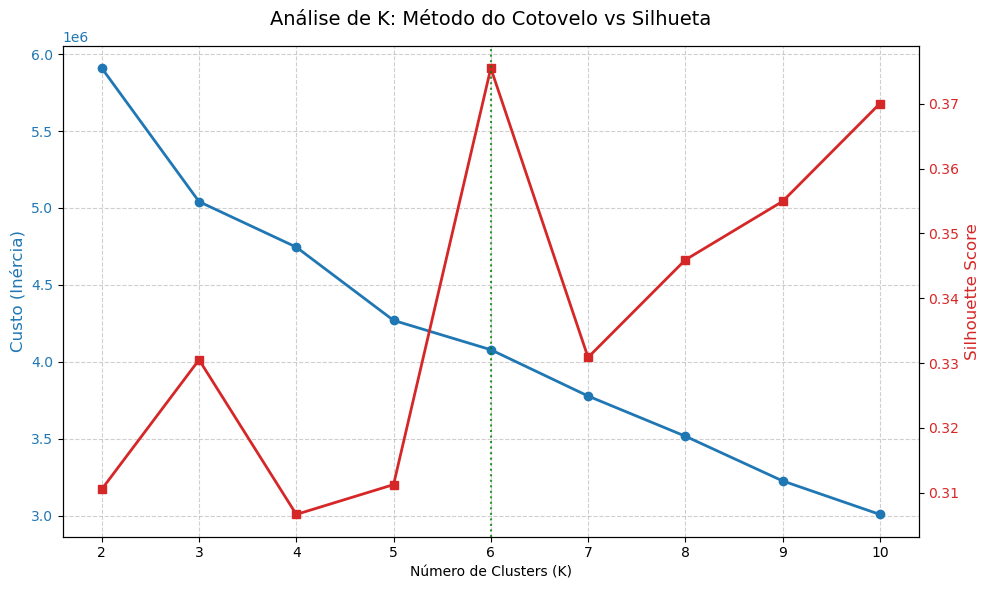

In [ ]:
# Converter o DataFrame do Spark para Pandas para facilitar o plot
df_plot = df_km_metrics.orderBy("k").toPandas()

fig, ax1 = plt.subplots(figsize=(10, 6))

# Configuração do primeiro eixo (Custo / Elbow)
color_elbow = 'tab:blue'
ax1.set_xlabel('Número de Clusters (K)')
ax1.set_ylabel('Custo (Inércia)', color=color_elbow, fontsize=12)
ax1.plot(df_plot['k'], df_plot['cost'], marker='o', color=color_elbow, linewidth=2, label='Custo')
ax1.tick_params(axis='y', labelcolor=color_elbow)
ax1.grid(True, linestyle='--', alpha=0.6)

# Criar o segundo eixo compartilhado
ax2 = ax1.twinx()
color_sil = 'tab:red'
ax2.set_ylabel('Silhouette Score', color=color_sil, fontsize=12)
ax2.plot(df_plot['k'], df_plot['silhouette'], marker='s', color=color_sil, linewidth=2, label='Silhueta')
ax2.tick_params(axis='y', labelcolor=color_sil)

# Título e ajustes finais
plt.title('Análise de K: Método do Cotovelo vs Silhueta', fontsize=14, pad=15)
plt.xticks(df_plot['k']) # Garante que todos os Ks apareçam no eixo X

# Adicionar uma linha vertical no melhor K que você encontrou (K=6)
plt.axvline(x=6, color='green', linestyle=':', alpha=0.8, label='Melhor K (6)')

fig.tight_layout()
plt.show()

Salto mais do que nítido para K = 6. K = 10 também poderia ser uma opção, pela silhueta alta. Se buscássemos algo mais granular, talvez poderia ser este o valor escolhido, mas K = 6 se mostra mais eficiente e simplificado.

#### 14.4.1.4. Resultados para K = 6 e K = 3

In [ ]:
k_kmeans_final = int(best_k_by_sil)  # ou fixe 3 se quiser coerência de negócio
# k_kmeans_final = 3

print("\n" + "="*90)
print(f"🚀 K-MEANS FINAL — K={k_kmeans_final}")
print("="*90)

kmeans = KMeans(featuresCol="pca_features", k=k_kmeans_final, seed=42, maxIter=100)
kmeans_model = kmeans.fit(df_final_clustering)
df_kmeans = kmeans_model.transform(df_final_clustering)

df_kmeans.groupBy("prediction").agg(
    F.count("*").alias("n_clientes"),
    F.mean("churn_rate_no_censor").alias("churn_rate_medio"),
    F.mean("flag_churn_algum_mes_no_censor").alias("pct_churn_algum_mes")
).orderBy("prediction").show(truncate=False)


🚀 K-MEANS FINAL — K=6
+----------+----------+--------------------+-------------------+
|prediction|n_clientes|churn_rate_medio    |pct_churn_algum_mes|
+----------+----------+--------------------+-------------------+
|0         |619360    |0.04868584035962459 |0.19213381555153708|
|1         |93884     |0.8091569349680423  |0.8587192705892378 |
|2         |127660    |0.08191967570786292 |0.39769700767664107|
|3         |169526    |0.054841031250549496|0.21937048004435897|
|4         |238425    |0.04332743256650141 |0.17225123204361958|
|5         |315144    |0.6865030636811157  |0.8140786434138045 |
+----------+----------+--------------------+-------------------+



**K-Means com K=6**

Clusters **1** e **5** são “claramente” de risco:
- Cluster 1: `churn_rate_medio` **0.809** e `pct_churn_algum_mes` **0.859**
- Cluster 5: `churn_rate_medio` **0.687** e `pct_churn_algum_mes` **0.814**

Os clusters **0/3/4** parecem “saudáveis/estáveis”:
- churn_rate ~ **0.043–0.055**
- pct churn algum mês ~ **0.172–0.219**

O cluster **2** é o que chama atenção:
- `churn_rate_medio` **0.082** (não tão alto)
- `pct_churn_algum_mes` **0.398** (bem alto)

**Conclusão (K=6):**
- Você não está apenas separando “churn vs não churn”.
- Você está separando pelo menos três perfis:
  1) **alto churn intenso** (clusters 1 e 5),
  2) **baixo churn** (0/3/4),
  3) **churn episódico** (cluster 2: muita gente com pelo menos 1 evento, mas taxa média não explode).

Isso é muito alinhado com a ideia de **volatilidade**: “episódicos” tendem a ser mais instáveis do que “baixo churn consistente”.

In [ ]:
k_kmeans_3 = 3 # Regra de negocio, para comparação com GMM

print("\n" + "="*90)
print(f"🚀 K-MEANS 3 — K={k_kmeans_3}")
print("="*90)

kmeans_3 = KMeans(featuresCol="pca_features", k=k_kmeans_3, seed=42, maxIter=100)
kmeans_model_3 = kmeans_3.fit(df_final_clustering)
df_kmeans_k3 = kmeans_model_3.transform(df_final_clustering)

df_kmeans_k3.groupBy("prediction").agg(
    F.count("*").alias("n_clientes"),
    F.mean("churn_rate_no_censor").alias("churn_rate_medio"),
    F.mean("flag_churn_algum_mes_no_censor").alias("pct_churn_algum_mes")
).orderBy("prediction").show(truncate=False)


🚀 K-MEANS 3 — K=3
+----------+----------+--------------------+-------------------+
|prediction|n_clientes|churn_rate_medio    |pct_churn_algum_mes|
+----------+----------+--------------------+-------------------+
|0         |390963    |0.7366543020743022  |0.8283392546097712 |
|1         |884903    |0.0569927519093704  |0.2330334511240215 |
|2         |288133    |0.048990673744346416|0.19136301638479453|
+----------+----------+--------------------+-------------------+



K-Means com K=3

Obteve-se:
- Um cluster “alto risco”: `churn_rate` 0.737, `pct` 0.828
- Dois clusters “baixo risco” com `churn_rate` 0.057 vs 0.049, e `pct` 0.233 vs 0.191

**Conclusão (K=3):** K=3 é mais simples, mas pode estar “colapsando” nuances: especialmente o padrão tipo “episódico” (que em K=6 aparece forte no cluster 2).

### 14.4.2. GMM - Gaussian Mixture Model

#### 14.4.2.1. Definição

Diferente do K-Means, que realiza uma atribuição rígida (*hard clustering*), o **Gaussian Mixture Model (GMM)** é um modelo probabilístico que assume que todos os pontos de dados são gerados a partir de uma mistura de um número finito de distribuições Gaussianas (normais) com parâmetros desconhecidos.

##### Fundamentos Matemáticos

O GMM tenta modelar a densidade de probabilidade dos dados $p(x)$ como uma soma ponderada de $K$ distribuições normais multivariadas:

$$p(x) = \sum_{k=1}^{K} \phi_k \mathcal{N}(x \mid \mu_k, \Sigma_k)$$

Onde:
* $\phi_k$: É o **peso de mistura** do componente $k$, sendo que $\sum \phi_k = 1$.
* $\mu_k$: Representa o **vetor de médias** (centro) do componente $k$.
* $\Sigma_k$: É a **matriz de covariância**, que define a forma, volume e orientação do cluster.

##### Expectation-Maximization (EM)

O ajuste do modelo é feito através do algoritmo EM, que busca maximizar a log-verossimilhança:
1.  **E-step (Expectation):** Calcula a probabilidade de cada ponto $x_i$ pertencer a cada cluster $k$ (atribuição suave ou *soft assignment*).
2.  **M-step (Maximization):** Atualiza os parâmetros $\phi$, $\mu$ e $\Sigma$ para maximizar a verossimilhança dos dados dada as atribuições.

Essa abordagem permite que o GMM identifique clusters com diferentes tamanhos e formatos elípticos, o que o torna ideal para capturar a **volatilidade** no comportamento dos clientes.

#### 14.4.2.2. Execução

In [ ]:
from pyspark.ml.clustering import GaussianMixture
from pyspark.ml.evaluation import ClusteringEvaluator

print("\n" + "="*90)
print("🚀 GMM — CLUSTERIZAÇÃO DE VOLATILIDADE")
print("="*90)

gmm = GaussianMixture(
    featuresCol="pca_features",
    k=3, # Consistente, Incerto, Declínio - como declarado na sessão "propostas de agrupamento"
    seed=42,
    maxIter=100
)

gmm_model = gmm.fit(df_final_clustering)
df_gmm = gmm_model.transform(df_final_clustering)

# Ver proporções
df_gmm.groupBy("prediction").count().show()


🚀 GMM — CLUSTERIZAÇÃO DE VOLATILIDADE
+----------+------+
|prediction| count|
+----------+------+
|         1|321588|
|         2|832423|
|         0|409988|
+----------+------+



#### 14.4.2.3. Mensuração de Incerteza via Entropia de Shannon

##### Definição

Uma das maiores vantagens do GMM sobre algoritmos tradicionais é a capacidade de medir a **incerteza da classificação**. Em vez de apenas dizer a qual cluster um cliente pertence, o modelo nos fornece um vetor de probabilidades.

Para quantificar o quão "confuso" o modelo está em relação a um cliente, calculamos a **Entropia de Shannon**:

$$H(x_i) = -\sum_{k=1}^{K} P(C_k | x_i) \log P(C_k | x_i)$$

* Entropia Baixa: O modelo tem alta confiança. Uma das probabilidades está próxima de $1$ e as outras de $0$.
* Entropia Alta: O modelo está incerto. As probabilidades estão distribuídas entre dois ou mais clusters (ex: o cliente está na fronteira entre "Fiel" e "Risco de Churn").

No código a seguir, adiciona-se um termo constante ($10^{-12}$) para evitar o cálculo de $\log(0)$, garantindo a estabilidade numérica da operação.

##### Execução

In [ ]:
from pyspark.sql import functions as F
from pyspark.ml.functions import vector_to_array

print("\n" + "="*90)
print("🧠 GMM — ENTROPIA (INCERTEZA) [CORRIGIDO]")
print("="*90)

df_gmm_entropy = (df_gmm
    .withColumn("prob_arr", vector_to_array("probability"))
    .withColumn(
        "entropy",
        F.expr("""
            -aggregate(
                prob_arr,
                cast(0.0 as double),
                (acc, x) -> acc + x * log(x + 1e-12)
            )
        """)
    )
)

df_gmm_entropy.select("entropy").describe().show()

df_gmm_entropy.groupBy("prediction").agg(
    F.count("*").alias("n_clientes"),
    F.mean("entropy").alias("entropy_media"),
    F.expr("percentile_approx(entropy, 0.5)").alias("entropy_mediana"),
    F.mean("churn_rate_no_censor").alias("churn_rate_medio"),
    F.mean("flag_churn_algum_mes_no_censor").alias("pct_churn_algum_mes")
).orderBy("prediction").show(truncate=False)


🧠 GMM — ENTROPIA (INCERTEZA) [CORRIGIDO]
+-------+--------------------+
|summary|             entropy|
+-------+--------------------+
|  count|             1563999|
|   mean| 0.12035502243002494|
| stddev|  0.2634747492504076|
|    min|3.995034641576909...|
|    max|    1.09861228866511|
+-------+--------------------+

+----------+----------+-------------------+--------------------+-------------------+-------------------+
|prediction|n_clientes|entropy_media      |entropy_mediana     |churn_rate_medio   |pct_churn_algum_mes|
+----------+----------+-------------------+--------------------+-------------------+-------------------+
|0         |409988    |0.13732446373980423|0.005906053327759478|0.16798850998644513|0.4552060060294448 |
|1         |321588    |0.23959473004230852|0.01510178134271038 |0.10675849111051938|0.2845068845852457 |
|2         |832423    |0.06593157858557017|0.00130978322552334 |0.2995447506509788 |0.368895381314548  |
+----------+----------+-------------------+-----

**Perfil dos Agrupamentos**

- Cluster 2 — O "Porto Seguro" (Baixa Volatilidade): é o maior grupo ($832.423$ clientes) e o mais estável, com a menor entropia média ($0.065$).Embora tenha o maior `churn_rate_medio` ($29.9\%$), o modelo tem muita certeza sobre quem são esses clientes. É um grupo previsível, possivelmente de clientes com comportamento de churn já consolidado ou padrões de uso muito lineares.

- Cluster 1 — A Zona de Incerteza (Alta Volatilidade): apresenta a maior entropia média ($0.239$) e mediana ($0.015$).Estes são os clientes representados pelos pontos amarelos no gráfico (a seguir). O comportamento deles oscila entre as definições dos outros grupos. Apesar de terem o menor churn rate médio ($10.6\%$), o risco reside na instabilidade: eles são os candidatos ideais para monitoramento preventivo, pois o modelo ainda está "aprendendo" a direção que eles tomarão.

- Cluster 0 — Risco Intermediário: possui a maior taxa de churn acumulada (`pct_churn_algum_mes` de $45.5\%$). A entropia de $0.137$ sugere que, embora o modelo os identifique bem, há uma parcela considerável em transição.

**A discrepância entre a Média e a Mediana de entropia (especialmente no Cluster 1, onde a média é 15x maior que a mediana) indica uma distribuição de cauda longa.**

Insight: A maioria dos clientes está muito bem classificada (mediana próxima de 0), mas existe uma minoria crítica (os pontos amarelados no scatter plot a seguir) que puxa a média de incerteza para cima. São justamente esses clientes que geram os desvios de performance nas métricas de negócio.

### 14.4.3. Comparação entre algoritmos

In [ ]:
print("\n" + "="*90)
print("📌 COMPARAÇÃO — PERFIL DOS CLUSTERS")
print("="*90)

km_summary = (df_kmeans.groupBy(F.col("prediction").alias("cluster_kmeans"))
    .agg(
        F.count("*").alias("n_clientes"),
        F.mean("churn_rate_no_censor").alias("churn_rate_medio"),
        F.mean("flag_churn_algum_mes_no_censor").alias("pct_churn_algum_mes")
    )
)

km_3_summary = (df_kmeans_k3.groupBy(F.col("prediction").alias("cluster_kmeans"))
    .agg(
        F.count("*").alias("n_clientes"),
        F.mean("churn_rate_no_censor").alias("churn_rate_medio"),
        F.mean("flag_churn_algum_mes_no_censor").alias("pct_churn_algum_mes")
    )
)

gmm_summary = (df_gmm_entropy.groupBy(F.col("prediction").alias("cluster_gmm"))
    .agg(
        F.count("*").alias("n_clientes"),
        F.mean("entropy").alias("entropy_media"),
        F.mean("churn_rate_no_censor").alias("churn_rate_medio"),
        F.mean("flag_churn_algum_mes_no_censor").alias("pct_churn_algum_mes")
    )
)

print("🔹 KMeans summary - K = 6")
km_summary.orderBy("cluster_kmeans").show(truncate=False)

print("🔹 KMeans summary - K = 3")
km_3_summary.orderBy("cluster_kmeans").show(truncate=False)

print("🔹 GMM summary")
gmm_summary.orderBy("cluster_gmm").show(truncate=False)


📌 COMPARAÇÃO — PERFIL DOS CLUSTERS
🔹 KMeans summary - K = 6
+--------------+----------+--------------------+-------------------+
|cluster_kmeans|n_clientes|churn_rate_medio    |pct_churn_algum_mes|
+--------------+----------+--------------------+-------------------+
|0             |619360    |0.04868584035962459 |0.19213381555153708|
|1             |93884     |0.8091569349680423  |0.8587192705892378 |
|2             |127660    |0.08191967570786292 |0.39769700767664107|
|3             |169526    |0.054841031250549496|0.21937048004435897|
|4             |238425    |0.04332743256650141 |0.17225123204361958|
|5             |315144    |0.6865030636811157  |0.8140786434138045 |
+--------------+----------+--------------------+-------------------+

🔹 KMeans summary - K = 3
+--------------+----------+--------------------+-------------------+
|cluster_kmeans|n_clientes|churn_rate_medio    |pct_churn_algum_mes|
+--------------+----------+--------------------+-------------------+
|0             |

### 14.4.4. Gráficos para visualização

#### 14.4.4.1. Extrair PC1/PC2 do vetor pca_features (Spark → colunas)

In [ ]:
from pyspark.ml.functions import vector_to_array

def add_pc1_pc2(df, vec_col="pca_features"):
    return (df
        .withColumn("pc_arr", vector_to_array(vec_col))
        .withColumn("pc1", F.col("pc_arr")[0])
        .withColumn("pc2", F.col("pc_arr")[1])
        .drop("pc_arr")
    )

df_km_plot = add_pc1_pc2(df_kmeans)
df_km_3_plot = add_pc1_pc2(df_kmeans_k3)
df_gmm_plot = add_pc1_pc2(df_gmm_entropy)

In [ ]:
sample_n = 50000  # ajuste: 20k~100k

km_pd = (df_km_plot
    .select("pc1", "pc2", F.col("prediction").alias("cluster"))
    .orderBy(F.rand(seed=42))
    .limit(sample_n)
    .toPandas())

km_3_pd = (df_km_3_plot
    .select("pc1", "pc2", F.col("prediction").alias("cluster"))
    .orderBy(F.rand(seed=42))
    .limit(sample_n)
    .toPandas())

gmm_pd = (df_gmm_plot
    .select("pc1", "pc2", F.col("prediction").alias("cluster"), "entropy")
    .orderBy(F.rand(seed=42))
    .limit(sample_n)
    .toPandas())

#### 14.4.4.2. Plot “incerteza” (entropia) no GMM

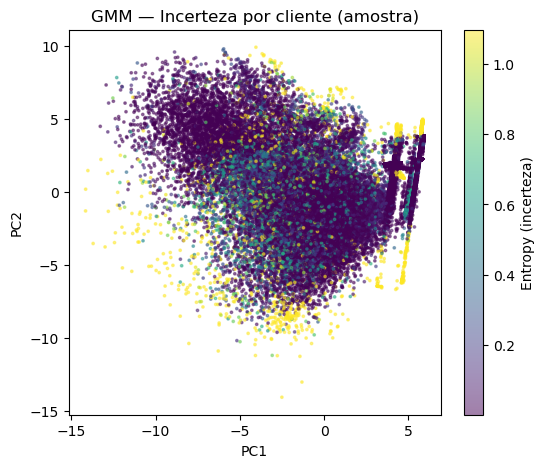

In [ ]:
plt.figure(figsize=(6,5))
plt.scatter(gmm_pd["pc1"], gmm_pd["pc2"], c=gmm_pd["entropy"], cmap="viridis", s=3, alpha=0.5)
plt.colorbar(label="Entropy (incerteza)")
plt.title("GMM — Incerteza por cliente (amostra)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

**1. Zonas de Conflito (Pontos Amarelos)**: Note que os pontos com maior entropia (amarelos, $> 0.8$) concentram-se justamente nas fronteiras de intersecção entre as grandes massas de dados. Isso faz todo sentido estatístico: são clientes cujo comportamento de PC1 e PC2 é ambíguo, não se encaixando perfeitamente em um perfil isolado.

**2. Núcleos de Certeza (Pontos Roxos)**: O "coração" de cada cluster (especialmente no topo à esquerda e na extrema direita) apresenta entropia próxima de $0$. Isso indica perfis de clientes muito bem definidos — o modelo "tem certeza" do que eles são.

**3. A Estrutura Linear à Direita**: Existe uma formação linear peculiar no lado direito do gráfico (próximo a PC1 = 5). O fato de haver pontos amarelos misturados a roxos nessa "linha" sugere que essa dimensão representa uma transição crítica.

**4. Insight de Negócio**: Os clientes representados pelos pontos amarelos são os seus "Clientes de Fronteira". Eles são os alvos mais interessantes para testes A/B ou campanhas de retenção, pois um pequeno deslocamento no comportamento deles pode mudar completamente sua classificação de cluster (ex: de "Saudável" para "Risco").

#### 14.4.4.3 Scatter plot (amostra) — KMeans e GMM

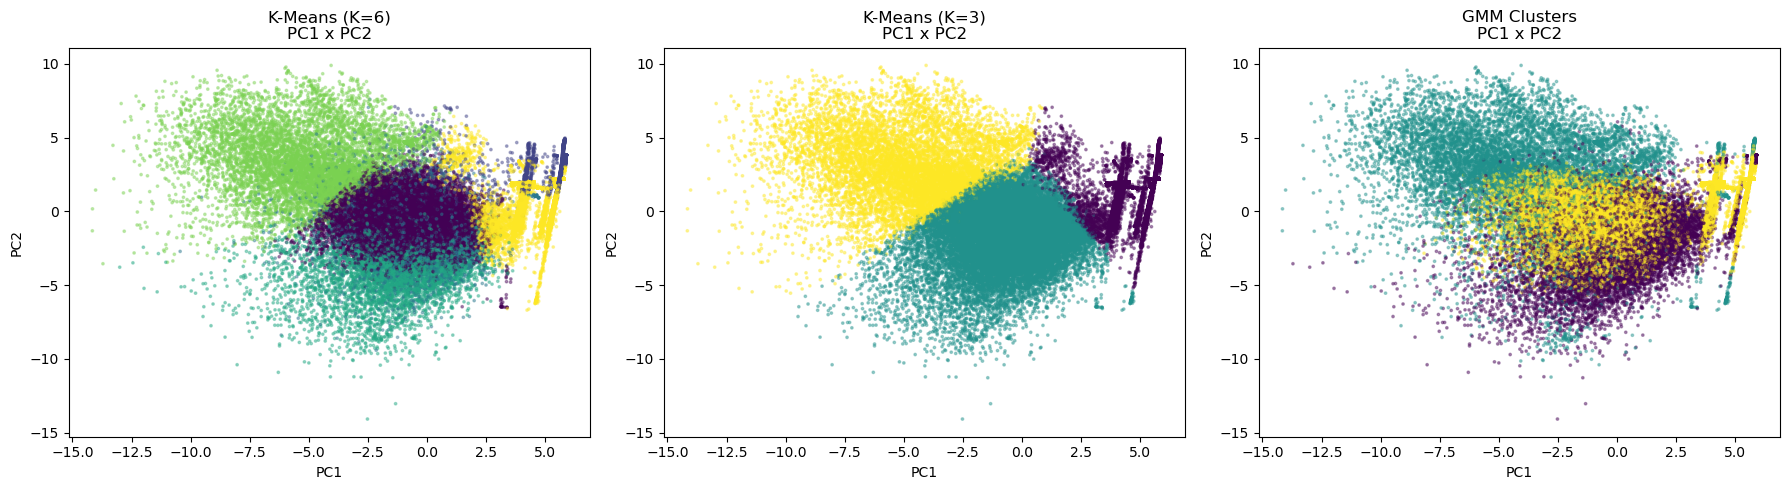

In [ ]:
# Plotar os tres graficos 
plt.figure(figsize=(18, 5))

# Gráfico 1: K-Means K=6
plt.subplot(1, 3, 1)
plt.scatter(km_pd["pc1"], km_pd["pc2"], c=km_pd["cluster"], s=3, alpha=0.4, cmap='viridis')
plt.title("K-Means (K=6)\nPC1 x PC2")
plt.xlabel("PC1")
plt.ylabel("PC2")

# Gráfico 2: K-Means K=3
plt.subplot(1, 3, 2)
plt.scatter(km_3_pd["pc1"], km_3_pd["pc2"], c=km_3_pd["cluster"], s=3, alpha=0.4, cmap='viridis')
plt.title("K-Means (K=3)\nPC1 x PC2")
plt.xlabel("PC1")
plt.ylabel("PC2")

# Gráfico 3: GMM
plt.subplot(1, 3, 3)
plt.scatter(gmm_pd["pc1"], gmm_pd["pc2"], c=gmm_pd["cluster"], s=3, alpha=0.4, cmap='viridis')
plt.title("GMM Clusters\nPC1 x PC2")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.tight_layout()
plt.show()

**Comparação Visual e Estrutural (K-Means vs. GMM)**

Ao observar os gráficos de dispersão (PC1 x PC2), é possível observar distinções fundamentais na forma como os algoritmos "enxergam" os dados:

- K-Means (K=3 e K=6): Cria divisões lineares e "limpas", conhecidas como células de Voronoi. No $K=3$, ele separa claramente um grupo de alto churn (amarelo) de dois grupos de baixo churn. No $K=6$, ele refina essa massa, mas as fronteiras continuam rígidas.

- GMM: Observe como as cores no gráfico do GMM se sobrepõem mais suavemente. Isso ocorre porque o GMM permite que os clusters tenham formas elípticas e diferentes orientações. Ele não apenas agrupa, mas modela a densidade. Onde você vê "nuvens" de pontos misturados, é onde a incerteza reside.

#### 14.4.4.4. Unindo resultados

**A "Incerteza" como Medida de Transição**

No gráfico de Incerteza por Cliente, os pontos amarelos (alta entropia) não são erros; eles são clientes em estado de transição.

* Como a base é composta pelo agrupado por cliente (ou seja, comportamento resumido ao longo das safras), um cliente com alta entropia é aquele cujo comportamento está mudando entre uma safra e outra (ex: ele era muito fiel e começou a oscilar, ou era inativo e está retornando). 

* O Cluster 1 do GMM (Entropia Média: $0.239$) é o "Laboratório de Volatilidade". Ele tem o menor churn rate imediato ($10.6\%$), mas a incerteza indica que o futuro desses clientes é imprevisível.

**Conclusão sobre a Dinâmica Temporal**

- Estabilidade (Cluster 2): com a menor entropia ($0.065$), o grupo representa o comportamento "inercial" da base. Seja "para o bem ou para o mal" (churn de $29\%$), esses clientes são consistentes ao longo das safras;

- Risco Silencioso (Cluster 0): possui o maior `pct_churn_algum_mes` ($45.5\%$). A entropia intermediária aqui sugere que o churn neste grupo não é um evento súbito, mas um processo de "derretimento" que o GMM consegue rastrear melhor que o K-Means.

**Em resumo...**

Enquanto o K-Means fornece uma fotografia estática da segmentação atual, o GMM pela entropia atua como um "termômetro" de volatilidade. A presença de alta incerteza nas fronteiras dos clusters revela que a base de clientes não é estática, mas que existe um fluxo constante de migração comportamental entre as safras, onde o Cluster 1 atua como a principal zona de transição de risco.

### 14.4.5. Proposta de Estratégia de Estabilização e Resgate (Conclusão)

O **Cluster 0** é identificado como o grupo de maior criticidade. Com um `pct_churn_algum_mes` de **45.5%**, este segmento não está apenas "em risco", mas já apresenta um comportamento histórico de ruptura consolidado em quase metade da sua base.

#### 14.4.5.1. Perfil de Risco

* Volatilidade: Entropia de $0.137$. O modelo tem uma confiança razoável na classificação, o que significa que o padrão de churn é identificável e recorrente;
* Comportamento: É o grupo onde o "derretimento" (attrition) é mais visível nas safras.

#### 14.4.5.2. Plano de Ação

**1. Intervenção Preventiva (Churn Control)** - Proposta de Churn da solução com algoritmo supervisionado

Como este grupo possui o maior volume de churn acumulado, deve-se aplicar uma régua de comunicação de re-engajamento agressivo:

* Trigger de inatividade: disparar ofertas personalizadas assim que o cliente atingir 50% do tempo médio de ciclo de compra/uso;
* Incentivos financeiros: utilização de cupons de *win-back* ou descontos progressivos para quebrar o ciclo de saída.

**2. Redução de Atrito no Atendimento**

Clientes neste cluster costumam ser sensíveis a falhas de processo. 

* Priorização: flag de "alto risco de churn" no CRM para atendimento prioritário no suporte/SAC;
* "Pesquisa de saída": Para os 45% que já churnaram, aplicar pesquisas qualitativas para identificar se o motivo é preço, produto ou concorrência.

**3. Monitoramento da Entropia**

Para os clientes neste cluster que apresentam entropia acima de 0.5:

* Clientes "em cima do muro": entre o Cluster 0 e o Cluster 1 (Incerteza);
* Ação: Teste A/B com ofertas de fidelização vs. ofertas de desconto pontual para mapear qual estímulo reduz a incerteza do modelo na safra seguinte.

#### 14.4.5.3. KPI de Sucesso Sugerido

**Meta:** Reduzir o `churn_rate_medio` de $16.7\%$ para $12\%$ em 3 safras, focando na conversão de clientes de "Alta Entropia" para o Cluster 2 (Estável). Como os clientes foram agrupados ao longo das safras, o sucesso dessa estratégia será visto quando, numa eventual próxima rodada do GMM, a densidade de pontos se deslocar do Cluster 0 para o Cluster 2, ou quando a entropia média do Cluster 0 diminuir, indicando que as ações de marketing tornaram o comportamento desses clientes mais previsível e estável.

### 14.4.6. Salvando base agrupada

In [ ]:
print("Salvando dataset clusterizado final (com GMM) para análises futuras de entropia...")
df_gmm_entropy.write.mode("overwrite").parquet(gold_path + "df_clustered_01_uncertainty_and_variability")
print("Dataset salvo em:", gold_path + "df_clustered_01_uncertainty_and_variability")

Salvando dataset clusterizado final (com GMM) para análises futuras de entropia...
Dataset salvo em: C:/Users/Gustavo/Downloads/datamaster/dados/gold/df_clustered_01_uncertainty_and_variability


## 14.5. Solução Proposta 2: Segmentação de Valor e Engajamento

Enquanto a análise anterior focou em comportamento temporal (volatilidade), esta foca em valor econômico e eficiência operacional. É a diferença entre saber como o cliente se move e saber quanto ele vale.

### 14.5.1. Melhor K

In [ ]:
print("\n" + "="*90)
print("🧪 BUSCA DO K ÓTIMO (ELBOW + SILHOUETTE)")
print("="*90)

df_sample = df_pca.sample(False, 0.10, seed=42).cache()

k_list = [3, 4, 5, 6, 7, 8] # Foco nos quadrantes de negócio (VIP, Dreno, etc), entao comecaremos com 3 (1 antes do esperado)
rows = []
evaluator = ClusteringEvaluator(featuresCol="pca_features", metricName="silhouette")

for k in k_list:
    km = KMeans(featuresCol="pca_features", k=k, seed=42, maxIter=30)
    km_model = km.fit(df_sample)
    pred = km_model.transform(df_sample)
    
    cost = km_model.summary.trainingCost
    sil = evaluator.evaluate(pred)
    
    rows.append((k, float(cost), float(sil)))
    print(f"K={k} | Cost={cost:.2f} | Silhouette={sil:.4f}")


🧪 BUSCA DO K ÓTIMO (ELBOW + SILHOUETTE)
K=3 | Cost=16093946.95 | Silhouette=0.2255
K=4 | Cost=14119459.07 | Silhouette=0.2652
K=5 | Cost=12627313.20 | Silhouette=0.3412
K=6 | Cost=11565923.01 | Silhouette=0.2882
K=7 | Cost=10057427.79 | Silhouette=0.3292
K=8 | Cost=9769583.92 | Silhouette=0.3155


✅ Melhor K por silhouette: 5


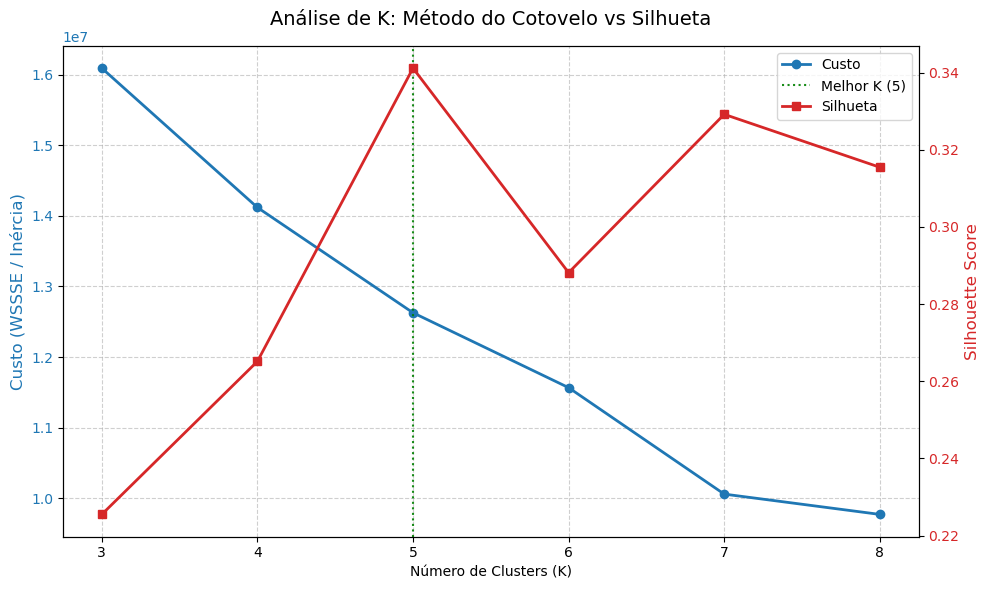

In [ ]:
# Criar df_km_metrics a partir do rows
df_km_metrics = spark.createDataFrame(rows, ["k", "cost", "silhouette"])

# Escolher o melhor K automaticamente por maior silhouette
best_k = (df_km_metrics
          .orderBy(F.col("silhouette").desc(), F.col("k").asc())
          .first()["k"])

print("✅ Melhor K por silhouette:", best_k)

# onverter para Pandas e plotar
df_plot = df_km_metrics.orderBy("k").toPandas()

fig, ax1 = plt.subplots(figsize=(10, 6))

# Eixo 1: Custo (Elbow)
color_elbow = 'tab:blue'
ax1.set_xlabel('Número de Clusters (K)')
ax1.set_ylabel('Custo (WSSSE / Inércia)', color=color_elbow, fontsize=12)
ax1.plot(df_plot['k'], df_plot['cost'], marker='o', color=color_elbow, linewidth=2, label='Custo')
ax1.tick_params(axis='y', labelcolor=color_elbow)
ax1.grid(True, linestyle='--', alpha=0.6)

# Eixo 2: Silhouette
ax2 = ax1.twinx()
color_sil = 'tab:red'
ax2.set_ylabel('Silhouette Score', color=color_sil, fontsize=12)
ax2.plot(df_plot['k'], df_plot['silhouette'], marker='s', color=color_sil, linewidth=2, label='Silhueta')
ax2.tick_params(axis='y', labelcolor=color_sil)

# Linha vertical no melhor K
ax1.axvline(x=best_k, color='green', linestyle=':', alpha=0.9, label=f'Melhor K ({best_k})')

# Título e ticks
plt.title('Análise de K: Método do Cotovelo vs Silhueta', fontsize=14, pad=15)
plt.xticks(df_plot['k'])

# Legenda combinada dos dois eixos
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

fig.tight_layout()
plt.show()

A segmentação proposta na seção propostas de agrupamento foi:

- "VIPs" (alta margem, alto uso);
- "Eficientes" (alta margem, baixo uso - baixo custo operacional);
- "Drenos" (baixo lucro, mas usam muito a plataforma); e
- "Ausentes" (baixo lucro, baixo uso da plataforma).

Porém, pelo resultado de `best_k`, vou considerar um grupo a mais, o qual logo descobrirei se é de fato um novo grupo ou se poderia ser nomeado subgrupo de um maior.

### 14.5.2. Treinamento Final - K-Means + Visualização inicial

In [ ]:
print("\n" + "="*90)
print(f"🚀 TREINAMENTO FINAL K-MEANS (K={best_k})")
print("="*90)

kmeans_final = KMeans(featuresCol="pca_features", k=best_k, seed=42, maxIter=50)
model_final = kmeans_final.fit(df_pca)
df_clustered = model_final.transform(df_pca)

summary = (df_clustered
    .groupBy("prediction")
    .agg(
        F.count("*").alias("n_cliente_mes"),
        F.mean("is_churn_m1").alias("taxa_churn_M1"),
        F.mean("margem_liquida_mensal").alias("margem_media"),
        F.expr("percentile_approx(margem_liquida_mensal, 0.5)").alias("margem_mediana"),
        F.mean("total_secs").alias("uso_medio_segundos"),
        F.expr("percentile_approx(total_secs, 0.5)").alias("uso_mediano_segundos"),
        F.mean("log_total_secs").alias("log_uso_medio"),
        F.mean("num_unq").alias("num_unq_medio"),
        F.mean("completed_songs_rate").alias("completed_rate_medio"),
        F.mean("early_drop_rate").alias("early_drop_medio"),
        F.mean("is_auto_renew").alias("pct_auto_renew"),
        F.mean("flag_plano_mensal").alias("pct_plano_mensal"),
        F.mean("flag_has_transactions").alias("pct_has_transactions")
    )
    .orderBy(F.desc("taxa_churn_M1"))
)

summary.show(truncate=False)


🚀 TREINAMENTO FINAL K-MEANS (K=5)
+----------+-------------+--------------------+-------------------+-----------------+------------------+--------------------+------------------+------------------+--------------------+-------------------+------------------+--------------------+--------------------+
|prediction|n_cliente_mes|taxa_churn_M1       |margem_media       |margem_mediana   |uso_medio_segundos|uso_mediano_segundos|log_uso_medio     |num_unq_medio     |completed_rate_medio|early_drop_medio   |pct_auto_renew    |pct_plano_mensal    |pct_has_transactions|
+----------+-------------+--------------------+-------------------+-----------------+------------------+--------------------+------------------+------------------+--------------------+-------------------+------------------+--------------------+--------------------+
|2         |1818929      |0.23704828500727626 |-60.366412164296676|-57.6811985      |97031.0089565934  |82108.481           |10.874924982014477|398.05242535580004|0.59

#### Primeiras observações:

##### Cluster 4 — Os "Super VIPs" (Os 1%)

- Perfil: Margem média altíssima (761.91) e uso consistente;
- Diferencial: Curiosamente, têm 0% de auto-renovação e plano mensal. Isso sugere que são clientes de planos Anuais ou Corporativos (pagamento único antecipado), o que explica a margem gigante;
- Papel do negócio: Taxa de churn M+1 é 0.0. São a base mais estável do ecossistema.

##### Cluster 3 — "Subgrupo": Os "VIPs Operacionais" (Engajados e Lucrativos)

- Perfil: Alta margem (79.24) e uso robusto (122k segundos);
- Diferencial: 100% têm transações recentes. É o maior grupo em volume ($4.1M$ clientes-mês);
- Papel no negócio: É a "vaca leiteira" (Cash Cow). Pagam bem e usam muito o serviço.

##### Cluster 0 — Os "Eficientes" (Baixo Custo, Margem Saudável)

- Perfil: Margem positiva (66.19), mas com o menor uso da plataforma (41k segundos);
- Diferencial: Quase 100% em planos mensais e auto-renovação;
- Papel no negócio: São clientes lucrativos porque não "oneram" a infraestrutura (uso baixo), mas mantêm a assinatura ativa.

##### Cluster 1 — Os "Drenos" (Alto Engajamento, Baixa Margem)

- Perfil: O uso mais extremo de todos (499k segundos), mas com margem quase nula (3.06);
- Diferencial: São usuários "Heavy Users", que provavelmente estão em planos promocionais ou antigos;
- Papel no negócio: Risco. O custo operacional de servir esses clientes é proporcionalmente alto em relação ao que eles pagam. 

##### Cluster 2 — Os "Ausentes em Risco" (Margem Negativa e Churn)

- Perfil: Margem negativa (-60.36) e maior taxa de churn (23.7%);

**Diagnóstico**: Este é o "grupo de risco" identificado. Eles rendem prejuízo e têm baixa probabilidade de renovação.

### 14.5.3. Gráficos

In [ ]:
print("\n" + "="*90)
print("📊 VISUALIZAÇÕES (AMOSTRAIS) — para performance")
print("="*90)

# =============================
# 7. VISUALIZAÇÕES (AMOSTRA)
# =============================
sample_frac_vis = 0.02  # 2% geralmente já dá muitos pontos em 11M; ajuste se precisar
seed = 42

df_vis = (df_clustered
          .select("prediction", "margem_liquida_mensal", "total_secs", "log_total_secs", "is_churn_m1", "safra", "pca_features")
          .sample(False, sample_frac_vis, seed=seed)
         )

# Converter pca_features (vector) -> colunas PC1, PC2 para scatter
from pyspark.ml.functions import vector_to_array
df_vis = df_vis.withColumn("pca_arr", vector_to_array("pca_features")) \
               .withColumn("PC1", F.col("pca_arr")[0]) \
               .withColumn("PC2", F.col("pca_arr")[1])

pdf = df_vis.select("prediction", "margem_liquida_mensal", "total_secs", "log_total_secs", "is_churn_m1", "safra", "PC1", "PC2").toPandas()

# Garantir tipos
pdf["prediction"] = pdf["prediction"].astype(int)
pdf["is_churn_m1"] = pdf["is_churn_m1"].astype(int)


📊 VISUALIZAÇÕES (AMOSTRAIS) — para performance


#### 14.5.3.1. Tamanho amostras + churn por cluster

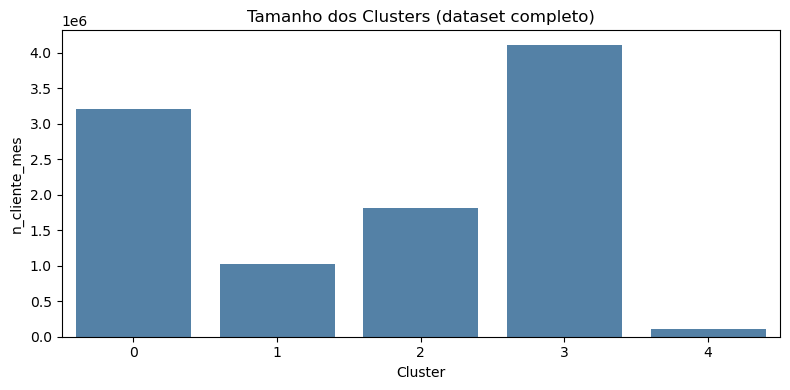

In [ ]:
sizes_pdf = (df_clustered.groupBy("prediction").count().orderBy("prediction").toPandas())
plt.figure(figsize=(8, 4))
sns.barplot(data=sizes_pdf, x="prediction", y="count", color="steelblue")
plt.title("Tamanho dos Clusters (dataset completo)")
plt.xlabel("Cluster")
plt.ylabel("n_cliente_mes")
plt.tight_layout()
plt.show()

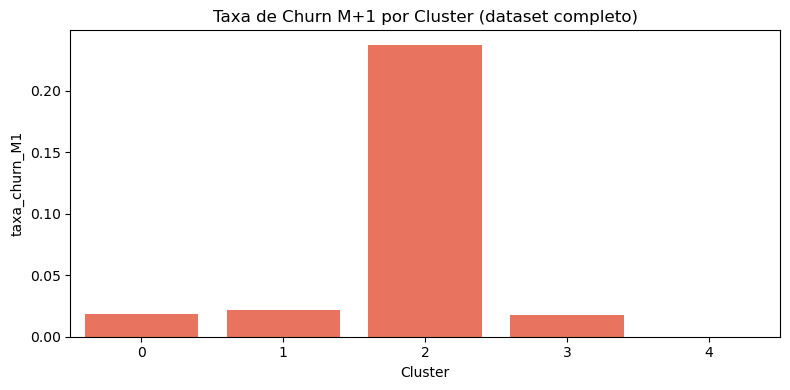

In [ ]:
churn_pdf = (df_clustered.groupBy("prediction")
             .agg(F.mean("is_churn_m1").alias("taxa_churn_M1"))
             .orderBy("prediction")
             .toPandas())

plt.figure(figsize=(8, 4))
sns.barplot(data=churn_pdf, x="prediction", y="taxa_churn_M1", color="tomato")
plt.title("Taxa de Churn M+1 por Cluster (dataset completo)")
plt.xlabel("Cluster")
plt.ylabel("taxa_churn_M1")
plt.tight_layout()
plt.show()

#### 14.5.3.2. Scatter-Plot: storytelling do PCA + KMeans

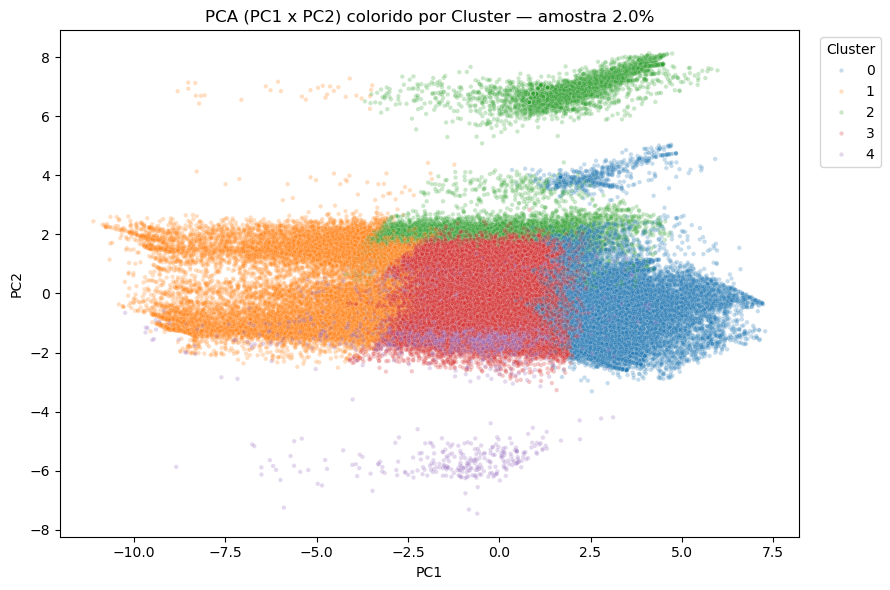

In [ ]:
plt.figure(figsize=(9, 6))
sns.scatterplot(data=pdf, x="PC1", y="PC2", hue="prediction", alpha=0.25, s=10, palette="tab10")
plt.title(f"PCA (PC1 x PC2) colorido por Cluster — amostra {sample_frac_vis*100:.1f}%")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

#### 14.5.3.3. Distribuição de Valor e Engajamento por cluster

C:\Users\Gustavo\AppData\Local\Temp\ipykernel_22964\1974209455.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pdf, x="prediction", y="margem_liquida_mensal", showfliers=False, palette="tab10")


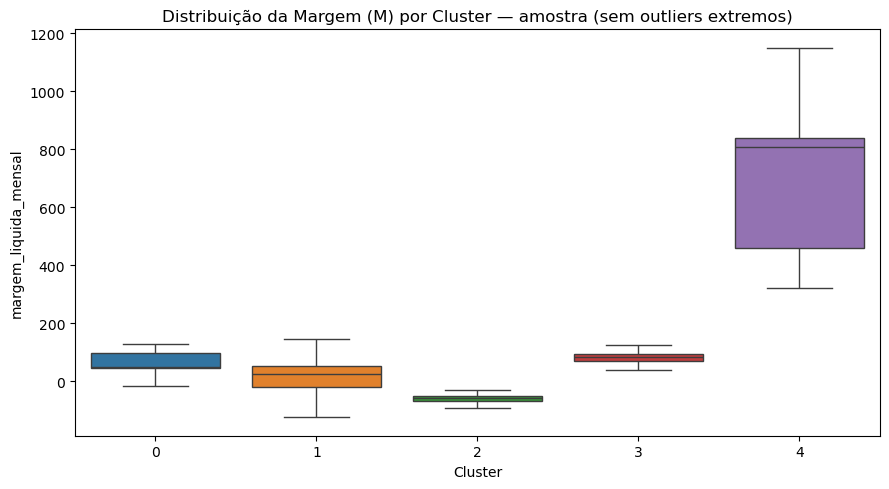

C:\Users\Gustavo\AppData\Local\Temp\ipykernel_22964\1974209455.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pdf, x="prediction", y="log_total_secs", showfliers=False, palette="tab10")


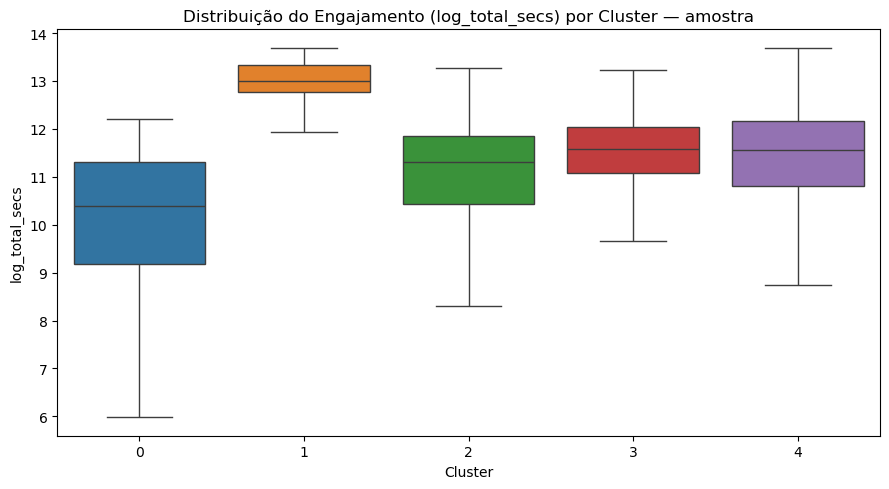

In [ ]:
# Margem
plt.figure(figsize=(9, 5))
sns.boxplot(data=pdf, x="prediction", y="margem_liquida_mensal", showfliers=False, palette="tab10")
plt.title("Distribuição da Margem (M) por Cluster — amostra (sem outliers extremos)")
plt.xlabel("Cluster")
plt.ylabel("margem_liquida_mensal")
plt.tight_layout()
plt.show()

# Uso (log_total_secs é mais legível)
plt.figure(figsize=(9, 5))
sns.boxplot(data=pdf, x="prediction", y="log_total_secs", showfliers=False, palette="tab10")
plt.title("Distribuição do Engajamento (log_total_secs) por Cluster — amostra")
plt.xlabel("Cluster")
plt.ylabel("log_total_secs")
plt.tight_layout()
plt.show()

#### 14.5.3.4. Heatmap

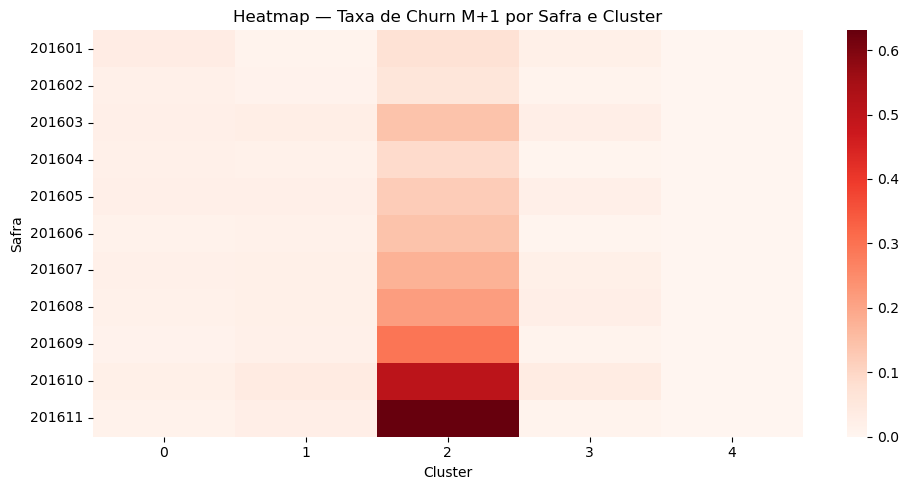

In [ ]:
heat = (df_clustered
        .groupBy("safra", "prediction")
        .agg(F.count("*").alias("n"), F.mean("is_churn_m1").alias("taxa_churn_M1"))
        .toPandas())

# pivôs para heatmap
heat_pivot = heat.pivot(index="safra", columns="prediction", values="taxa_churn_M1").sort_index()

plt.figure(figsize=(10, 5))
sns.heatmap(heat_pivot, cmap="Reds", annot=False)
plt.title("Heatmap — Taxa de Churn M+1 por Safra e Cluster")
plt.xlabel("Cluster")
plt.ylabel("Safra")
plt.tight_layout()
plt.show()

#### 14.5.3.5. Conclusão com base na análise conjunta dos gráficos

##### Análise dos Grupos

- Cluster 4 (Super VIPs - Roxo): O boxplot de margem isola este grupo no topo da escala ($> 800$), enquanto o gráfico de dispersão (PCA) o coloca em "ilhas" distintas na parte inferior do gráfico. Eles são poucos em volume, mas representam a elite financeira da base;

- Cluster 1 (Drenos - Laranja): É o campeão de engajamento no boxplot de `log_total_secs`, mas sua margem é achatada próxima a zero. No PCA, ele ocupa a extrema esquerda, indicando um comportamento de uso massivo que o distancia dos demais;

- Cluster 2 (Grupo de Risco/Ausentes - Verde): O gráfico de barras de churn e o heatmap são implacáveis: este grupo detém quase todo o risco da operação. No PCA, eles estão dispersos no topo, longe do "centro de gravidade" dos usuários pagantes.

##### Por que o Churn aumenta no Cluster 2 ao longo das safras?

No Heatmap, o Cluster 2 começa com um churn moderado em janeiro e termina em um vermelho profundo em novembro ($> 0.6$). Existem três razões técnicas e de negócio para isso:

1. **Efeito de Seleção (Deterioração da Safra)**: Clientes bons permanecem nos clusters de valor (0, 3 ou 4). O Cluster 2 atua como um "filtro de decantação". Quem sobra nele a cada mês são os clientes que perderam o interesse e estão apenas esperando o fim do ciclo para cancelar;

2. **Sazonalidade de Final de Ano**: O aumento drástico no final de 2016 sugere que o comportamento de churn nesse grupo é sazonal. Clientes com margem negativa ou baixo uso tendem a cortar gastos supérfluos no encerramento do ano fiscal ou períodos de renovação de contrato;

3. **Inércia Negativa**: Como a ABT agrupa clientes ao longo das safras, o Cluster 2 captura a "morte lenta". O modelo identifica que, quanto mais tempo um cliente passa com margem negativa (Cluster 2), maior a probabilidade estatística de ele finalmente efetivar o churn.

### 14.5.4. Conclusão Geral: Valor vs. Engajamento

A análise prova que engajamento nem sempre é valor. O Cluster 1 (Drenos) usa muito a plataforma, mas não gera caixa. Já o Cluster 0 (Eficientes) usa pouco, mas é altamente lucrativo. O sucesso da estratégia de retenção depende de tratar esses grupos de forma oposta.

#### Estratégia de Ação por Perfil

##### Cluster 4 - Elite/Anuais

**Blindagem**: Atendimento white-glove. Não precisam de descontos, mas de reconhecimento e novas funcionalidades. Trazer benefícios a mais, diferenciais.

##### Cluster 3 - Engajados VIP

**Fidelização**: Manter o uso alto. São os candidatos perfeitos para programas de pontos ou até mesmo cashback.

##### Cluster 0 - Eficientes

**Manutenção "silenciosa"**: "Não acorde a fera". Eles pagam e não usam. Evitar comunicações excessivas que os façam lembrar de cancelar a assinatura é uma boa abordagem.

##### Cluster 1 - Drenos

**Revisão**: Tentar migrá-los para planos que limitem o uso ou aumentem a margem. Usam do produto, mas pagam pouco por ele.

##### Cluster 2 - Risco Crítico

**Recuperação ou Descarte**: Campanhas de "Última Chance". Se não reativarem com ofertas agressivas, o churn é inevitável e aceitável (já que a margem é negativa).

### 14.5.5. Salvando base agrupada

In [ ]:
print("Salvando dataset clusterizado final (com PCA e clusters) para análises futuras...")
df_clustered.write.mode("overwrite").partitionBy("safra").parquet(gold_path + "df_clustered_02_value_and_engagement")
print("Dataset salvo em:", gold_path + "df_clustered_02_value_and_engagement")

Salvando dataset clusterizado final (com PCA e clusters) para análises futuras...
Dataset salvo em: C:/Users/Gustavo/Downloads/datamaster/dados/gold/df_clustered_02_value_and_engagement


## 14.6. Solução Proposta 3: Diagnóstico de Erros: Auditoria do Modelo Finalista - LightGBM

### 14.6.1. Carregando as predições do LightGBM

In [ ]:
df_cliente_mes_pca = spark.read.parquet(gold_path + "df_master_clustering_cliente_mes_pca")

In [ ]:
df_lightm_predictions = spark.read.parquet(gold_path + "df_predictions_lightgbm")

In [ ]:
df_lightm_predictions.groupBy("partition").count().show()

+---------+-------+
|partition|  count|
+---------+-------+
|      oot|1850732|
|    train|6262831|
|     test|1565303|
+---------+-------+



In [ ]:
df_err = (df_lightm_predictions
    .filter(F.col("partition").isin(["test", "oot"]))  # apenas fora de treino
    .withColumn("residual", F.col("target_win") - F.col("prediction_lgbm"))
    .withColumn("abs_residual", F.abs(F.col("residual"))))

In [ ]:
df_err.printSchema()

root
 |-- msno: string (nullable = true)
 |-- partition: string (nullable = true)
 |-- set: string (nullable = true)
 |-- target_win: double (nullable = true)
 |-- prediction_lgbm: double (nullable = true)
 |-- residual_lgbm: double (nullable = true)
 |-- daily_revenue_efficiency: double (nullable = true)
 |-- daily_revenue_efficiency_min_3: double (nullable = true)
 |-- daily_revenue_efficiency_min_3_is_sentinel: long (nullable = true)
 |-- flag_plano_mensal: long (nullable = true)
 |-- flag_plano_mensal_max_3: long (nullable = true)
 |-- flag_valid_fee_max_3: long (nullable = true)
 |-- log_total_plays: double (nullable = true)
 |-- log_total_plays_mean_3: double (nullable = true)
 |-- log_total_plays_mean_3_is_sentinel: long (nullable = true)
 |-- num_25: double (nullable = true)
 |-- num_50: double (nullable = true)
 |-- num_75: double (nullable = true)
 |-- num_985: double (nullable = true)
 |-- plays_per_unq_cap_min_6: double (nullable = true)
 |-- plays_per_unq_cap_min_6_is_sent

In [ ]:
df_err.select(
    F.mean("abs_residual"),
    F.expr("percentile_approx(abs_residual, 0.9)"),
    F.expr("percentile_approx(abs_residual, 0.95)")
).show()

+------------------+-------------------------------------------+--------------------------------------------+
| avg(abs_residual)|percentile_approx(abs_residual, 0.9, 10000)|percentile_approx(abs_residual, 0.95, 10000)|
+------------------+-------------------------------------------+--------------------------------------------+
|15.829586953854628|                         31.238655434048034|                            75.3930518805964|
+------------------+-------------------------------------------+--------------------------------------------+



In [ ]:
# Threshold top 5%
threshold = df_err.approxQuantile("abs_residual", [0.95], 0.001)[0]

df_err = df_err.withColumn("is_worst", (F.col("abs_residual") >= F.lit(threshold)).cast("int"))

print("Total registros:", df_err.count())
print("Worst registros:", df_err.filter("is_worst = 1").count())

Total registros: 3416035
Worst registros: 172501


### 14.6.2. Unindo público de predições errôneas + ABT `msno` + `safra`

In [ ]:
df_audit = (df_err
    .select("msno", "safra", "partition", "prediction_lgbm", "residual", "abs_residual", "is_worst")
    .join(df_cliente_mes_pca, on=["msno", "safra"], how="inner"))

In [ ]:
df_audit.count()

3416035

In [ ]:
df_audit.printSchema()

root
 |-- msno: string (nullable = true)
 |-- safra: integer (nullable = true)
 |-- partition: string (nullable = true)
 |-- target_win: double (nullable = true)
 |-- prediction_lgbm: double (nullable = true)
 |-- residual: double (nullable = true)
 |-- abs_residual: double (nullable = true)
 |-- total_secs: double (nullable = true)
 |-- num_unq: double (nullable = true)
 |-- total_plays: double (nullable = true)
 |-- log_total_secs: double (nullable = true)
 |-- completed_songs_rate: double (nullable = true)
 |-- early_drop_rate: double (nullable = true)
 |-- plays_per_unq_cap: double (nullable = true)
 |-- catalog_exploration_ratio_cap: double (nullable = true)
 |-- margem_liquida_mensal: double (nullable = true)
 |-- actual_amount_paid: float (nullable = true)
 |-- daily_revenue_efficiency: double (nullable = true)
 |-- revenue_per_hour_listened_cap: double (nullable = true)
 |-- usage_intensity_per_tenure_cap: double (nullable = true)
 |-- total_secs_ratio_ref_mean_3: double (nulla

In [ ]:
df_audit.groupBy("is_worst").agg(
    F.count("*").alias("n"),
    F.mean("abs_residual").alias("erro_medio"),
    F.mean("margem_liquida_mensal").alias("margem_media"),
    F.mean("total_secs").alias("uso_medio"),
    F.mean("is_auto_renew").alias("pct_auto_renew"),
    F.mean("tenure_faixa_te").alias("tenure_te_medio")
).show()

+--------+-------+-----------------+------------------+------------------+------------------+------------------+
|is_worst|      n|       erro_medio|      margem_media|         uso_medio|    pct_auto_renew|   tenure_te_medio|
+--------+-------+-----------------+------------------+------------------+------------------+------------------+
|       1| 172501|130.4983759511717| 41.84253711625912|129974.57992598023|0.5632141262949201|0.8602553514304666|
|       0|3243534|9.731152107532457|55.959379943886056| 133709.6338967611|0.9090165233353497|0.8611294998648371|
+--------+-------+-----------------+------------------+------------------+------------------+------------------+



| Métrica | Worst (Top 5%) | Resto | Interpretação |
|---------|----------------|-------|---------------|
| Erro médio | 130.50 | 9.73 | Worst erra 13x mais (esperado por construção) |
| Margem média | 41.84 | 55.96 | Worst tem 25% menos margem → clientes de menor valor |
| Uso médio | 129.9k seg | 133.7k seg | Uso ligeiramente menor (não é o principal driver) |
| Auto-renew | 56% | 91% | Worst tem 38% menos renovação automática → instabilidade contratual |
| Tenure TE | 0.860 | 0.861 | Praticamente igual (tenure não explica) |

**Perfil de Falha Identificado:**

O modelo falha desproporcionalmente em clientes de menor valor econômico e sem renovação automática (maior volatilidade comportamental). Esses clientes representam 5% da base, mas concentram erros 13x maiores. A partir deste ponto, vamos focar somente nos casos de `is_worst == 1`

### 14.6.3. K-Means

#### 14.6.3.1. Melhor K

In [ ]:
print("\n" + "="*90)
print("🧪 CLUSTERING DOS PIORES ERROS — BUSCA DE K ÓTIMO")
print("="*90)

# 1. FILTRAR APENAS OS WORST
df_worst = df_audit.filter(F.col("is_worst").isin(1))
print(f"✔ Registros para clustering (Top 5% erros): {df_worst.count():,}")

# 2. BUSCA DE K (SILHOUETTE)
k_list = [3, 4, 5, 6]
rows = []
evaluator = ClusteringEvaluator(featuresCol="pca_features", metricName="silhouette")

for k in k_list:
    km = KMeans(featuresCol="pca_features", k=k, seed=42, maxIter=50)
    model = km.fit(df_worst)
    pred = model.transform(df_worst)
    
    sil = evaluator.evaluate(pred)
    cost = model.summary.trainingCost
    
    rows.append((k, float(cost), float(sil)))
    print(f"K={k} | Cost={cost:.2f} | Silhouette={sil:.4f}")

# DataFrame com métricas
df_k_metrics = spark.createDataFrame(rows, ["k", "cost", "silhouette"])

# Melhor K por silhouette
best_k = (df_k_metrics
          .orderBy(F.col("silhouette").desc(), F.col("k").asc())
          .first()["k"])

print(f"\n✅ Melhor K por silhouette: {best_k}")


🧪 CLUSTERING DOS PIORES ERROS — BUSCA DE K ÓTIMO
✔ Registros para clustering (Top 5% erros): 172,501
K=3 | Cost=2618759.11 | Silhouette=0.3678
K=4 | Cost=2238241.94 | Silhouette=0.3664
K=5 | Cost=1864410.70 | Silhouette=0.4258
K=6 | Cost=1717845.48 | Silhouette=0.4259

✅ Melhor K por silhouette: 6


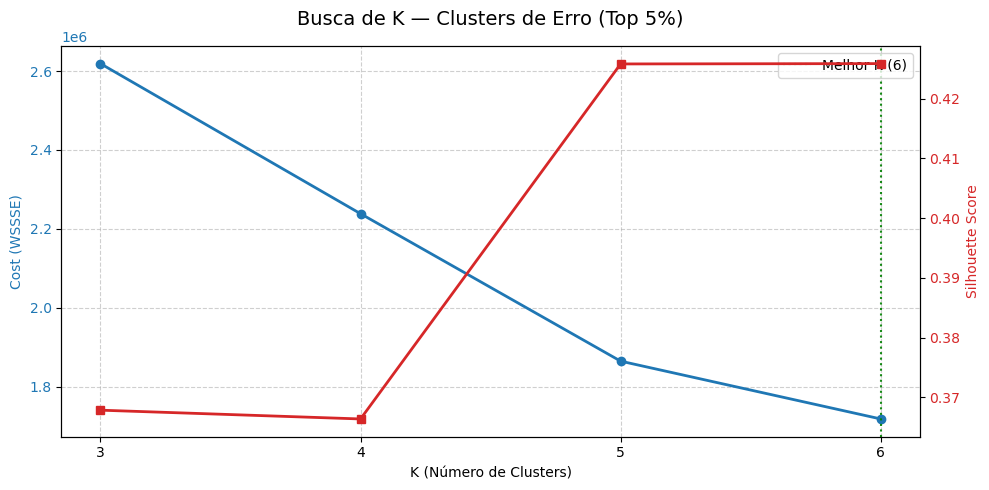

In [ ]:
pdf_k = df_k_metrics.orderBy("k").toPandas()

fig, ax1 = plt.subplots(figsize=(10, 5))

# Eixo 1: Cost
ax1.set_xlabel('K (Número de Clusters)')
ax1.set_ylabel('Cost (WSSSE)', color='tab:blue')
ax1.plot(pdf_k['k'], pdf_k['cost'], marker='o', color='tab:blue', linewidth=2)
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True, linestyle='--', alpha=0.6)

# Eixo 2: Silhouette
ax2 = ax1.twinx()
ax2.set_ylabel('Silhouette Score', color='tab:red')
ax2.plot(pdf_k['k'], pdf_k['silhouette'], marker='s', color='tab:red', linewidth=2)
ax2.tick_params(axis='y', labelcolor='tab:red')

# Linha no melhor K
ax1.axvline(x=best_k, color='green', linestyle=':', alpha=0.9, label=f'Melhor K ({best_k})')

plt.title('Busca de K — Clusters de Erro (Top 5%)', fontsize=14, pad=15)
plt.xticks(pdf_k['k'])
ax1.legend(loc='upper right')
fig.tight_layout()
plt.show()

#### 14.6.3.2. Execução com melhor K

In [ ]:
# 4. TREINAMENTO FINAL COM MELHOR K
print("\n" + "="*90)
print(f"🚀 TREINAMENTO FINAL — K={best_k}")
print("="*90)

kmeans_final = KMeans(featuresCol="pca_features", k=best_k, seed=42, maxIter=100)
model_final = kmeans_final.fit(df_worst)
df_worst_clustered = model_final.transform(df_worst)


🚀 TREINAMENTO FINAL — K=6


In [ ]:
# 5. PERFIL DOS CLUSTERS DE ERRO
summary_err = (df_worst_clustered
    .groupBy("prediction")
    .agg(
        F.count("*").alias("n"),
        F.mean("abs_residual").alias("erro_medio_abs"),
        F.expr("percentile_approx(abs_residual, 0.5)").alias("erro_p50"),
        F.mean("residual").alias("bias_medio"),  # + subestima / - superestima
        
        F.mean("target_win").alias("margem_real_media"),
        F.mean("prediction_lgbm").alias("predicao_media"),
        
        F.mean("margem_liquida_mensal").alias("margem_M_media"),
        F.mean("total_secs").alias("uso_medio_seg"),
        F.mean("log_total_secs").alias("log_uso_medio"),
        F.mean("num_unq").alias("num_unq_medio"),
        
        F.mean("is_auto_renew").alias("pct_auto_renew"),
        F.mean("flag_plano_mensal").alias("pct_plano_mensal"),
        F.mean("flag_has_transactions").alias("pct_has_transactions"),
        
        F.mean("tenure_faixa_te").alias("tenure_te_medio"),
        F.mean("faixa_idade_te").alias("idade_te_medio"),
        F.mean("revenue_tier_te").alias("revenue_tier_te_medio")
    )
    .orderBy(F.desc("erro_medio_abs"))
)

print("\n📊 PERFIL DOS CLUSTERS DE ERRO:")
summary_err.show(truncate=False)


📊 PERFIL DOS CLUSTERS DE ERRO:
+----------+-----+------------------+------------------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+------------------+--------------------+------------------+--------------------+------------------+------------------+---------------------+
|prediction|n    |erro_medio_abs    |erro_p50          |bias_medio         |margem_real_media  |predicao_media     |margem_M_media     |uso_medio_seg     |log_uso_medio     |num_unq_medio     |pct_auto_renew      |pct_plano_mensal  |pct_has_transactions|tenure_te_medio   |idade_te_medio    |revenue_tier_te_medio|
+----------+-----+------------------+------------------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+------------------+--------------------+------------------+--------------------+------------------+------------------+---------------------+
|1         |30500|144.5

Pontos de atenção:

- `bias_medio` indo de valores positivos até negativos, com valores bem dispersos;
- `feat_te`: nenhuma categórica com target encoding entrega separação clara dos usuários de maior erro.

#### 14.6.3.3. Resultados

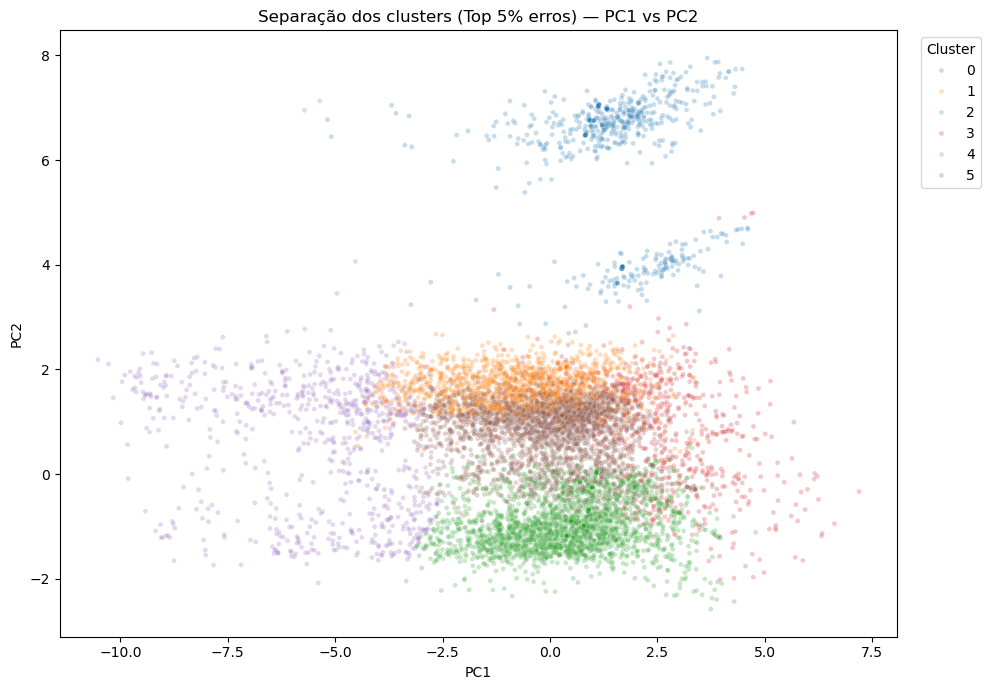

In [ ]:
df_plot = (df_worst_clustered
    .withColumn("pca_arr", vector_to_array(F.col("pca_features")))
    .withColumn("pc1", F.col("pca_arr")[0])
    .withColumn("pc2", F.col("pca_arr")[1])
    .select("pc1", "pc2", "prediction", "partition", "abs_residual")
)

pdf = df_plot.sample(withReplacement=False, fraction=0.05, seed=42).toPandas()

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=pdf, x="pc1", y="pc2",
    hue="prediction",
    alpha=0.25, s=12,
    palette="tab10"
)
plt.title("Separação dos clusters (Top 5% erros) — PC1 vs PC2")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

- Isolamento do Erro Tipo 0: Note que o Cluster 0 (azul claro) aparece em "ilhas" isoladas no topo do gráfico. Isso indica que esses erros ocorrem em perfis de clientes muito específicos e geograficamente (matematicamente) distantes da massa principal. É um erro de "nicho";

- A Massa Central de Incerteza: Os Clusters 5, 1 e 2 estão densamente sobrepostos no centro. Isso explica por que o modelo se confunde: os atributos desses clientes (PC1 e PC2) são muito parecidos, mas seus resultados de margem real são opostos. O modelo não tem variáveis suficientes para separar o "joio do trigo" nessa zona central.

- Dispersão do Cluster 4: O Cluster 4 (roxo) está muito espalhado à esquerda. Isso corrobora o fato de serem os Heavy Users (alto uso). O modelo erra neles por causa da alta variabilidade do comportamento de uso intenso.

In [ ]:
# 6. ANÁLISE POR PARTIÇÃO (TEST vs OOT)
summary_part = (df_worst_clustered
    .groupBy("partition", "prediction")
    .agg(
        F.count("*").alias("n"),
        F.mean("abs_residual").alias("erro_medio_abs"),
        F.mean("residual").alias("bias_medio")
    )
    .orderBy("partition", "prediction")
)

print("\n📊 ERRO POR PARTIÇÃO (TEST vs OOT):")
summary_part.show(truncate=False)


📊 ERRO POR PARTIÇÃO (TEST vs OOT):
+---------+----------+-----+------------------+-------------------+
|partition|prediction|n    |erro_medio_abs    |bias_medio         |
+---------+----------+-----+------------------+-------------------+
|oot      |0         |6699 |124.33344481389751|106.69686642709442 |
|oot      |1         |10332|137.27447049680757|72.81934302412537  |
|oot      |2         |22614|117.16609025733842|-114.13719302080754|
|oot      |3         |5572 |127.09060710687567|-114.10432307874716|
|oot      |4         |6784 |127.41324935552377|-68.70352024894646 |
|oot      |5         |28024|138.7344702508955 |-136.04613426544327|
|test     |0         |5558 |116.65383574611558|-50.2951608865458  |
|test     |1         |20168|148.24659810702528|93.87152852346854  |
|test     |2         |26605|121.19814858970321|-118.53468740932908|
|test     |3         |6085 |124.59896064406692|-107.23608537840985|
|test     |4         |8148 |132.62142955108857|-32.14554738943121 |
|test     |5

A análise das partições revela que os perfis de erro identificados não são aleatórios, mas sim **deficiências estruturais** do modelo que se repetem ao longo do tempo.

* **Consistência Sistêmica:** os Clusters 1 (Subestimação) e 5 (Superestimação) apresentam erros persistentes em ambas as bases, sugerindo a criação de possíveis **regras de compensação pós-modelo**;
* **Alerta de Instabilidade (Cluster 0):** inversão de viés no Cluster 0, passando de superestimação no teste para uma subestimação severa no OOT. É interessante monitorar bem ao utilizar predições para este grupo em safras recentes;
* **Confiabilidade do MAE:** a variação do Erro Médio Absoluto entre as bases é inferior a 10% na maioria dos clusters, o que valida a utilização desta auditoria como base para o diagnóstico de falhas com os stakeholders.

In [ ]:
# 7. APLICAR MODELO NO DATASET COMPLETO (para calcular prob_worst por cluster)
print("\n" + "="*90)
print("🔍 PROBABILIDADE DE ERRO ALTO POR CLUSTER (BASE COMPLETA)")
print("="*90)

df_audit_clustered = model_final.transform(df_audit)

prob_worst = (df_audit_clustered
    .groupBy("prediction")
    .agg(
        F.count("*").alias("n_total"),
        F.sum("is_worst").alias("n_worst"),
        F.mean("is_worst").alias("prob_worst"),
        F.mean("abs_residual").alias("erro_medio_abs"),
        F.mean("margem_liquida_mensal").alias("margem_media"),
        F.mean("is_auto_renew").alias("pct_auto_renew")
    )
    .orderBy(F.desc("prob_worst"))
)

print("\n📊 PROBABILIDADE DE ESTAR NO TOP 5% DE ERRO:")
prob_worst.show(truncate=False)


🔍 PROBABILIDADE DE ERRO ALTO POR CLUSTER (BASE COMPLETA)

📊 PROBABILIDADE DE ESTAR NO TOP 5% DE ERRO:
+----------+-------+-------+--------------------+------------------+------------------+--------------------+
|prediction|n_total|n_worst|prob_worst          |erro_medio_abs    |margem_media      |pct_auto_renew      |
+----------+-------+-------+--------------------+------------------+------------------+--------------------+
|0         |25163  |12257  |0.48710408138934147 |74.85322577120148 |-57.00804101218457|0.35842308150856417 |
|5         |288467 |53936  |0.18697459328103389 |37.54356923362797 |152.0913032886376 |0.005900154957066146|
|1         |401697 |30500  |0.07592787598612885 |25.745314739085906|-63.76402386472962|1.0                 |
|3         |224509 |11657  |0.051922194655893525|13.36319652406007 |72.12768313656163 |0.9024894324949111  |
|4         |332126 |14932  |0.04495884092181883 |20.685212518093678|12.394906518561191|0.8626816328742706  |
|2         |2144073|49219

Ao expandir a análise para a base completa, é possível quantificar a **confiabilidade** das predições de acordo com o perfil do cliente:

* **Incerteza Crítica (Cluster 0):** quase **50% das predições** para este grupo resultam em erros severos (Top 5%). Decisões automáticas de negócio devem ser suspensas para este perfil até o ajuste das features;
* **Vulnerabilidade Contratual (Cluster 5):** clientes fora do regime de renovação automática apresentam uma probabilidade de erro **8x maior** que a média da base estável. O modelo superestima a retenção de valor onde não há recorrência garantida;
* **Eficiência Operacional (Cluster 2):** **85% da base total** (Cluster 2) opera em uma zona de segurança, com erro médio absoluto inferior a 10 unidades. O modelo é altamente recomendável para automações em decisões de negócio neste segmento.

#### Gráficos


📊 VISUALIZAÇÕES


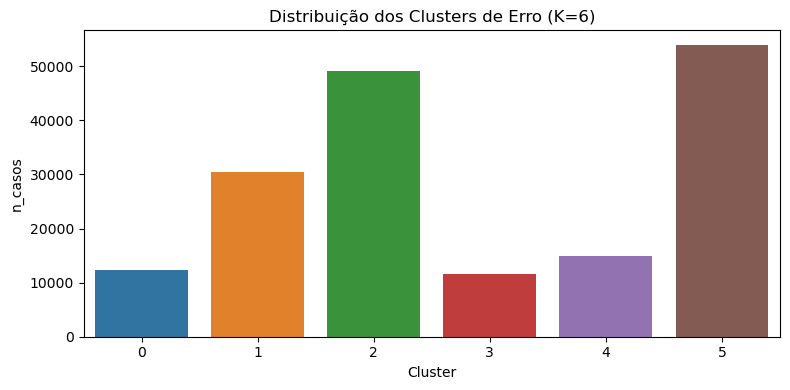

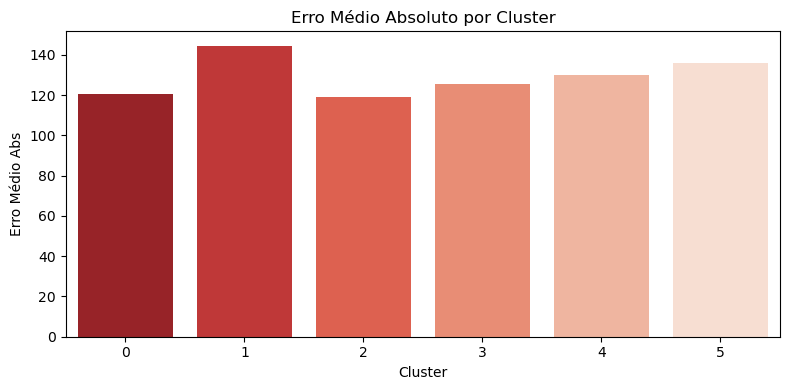

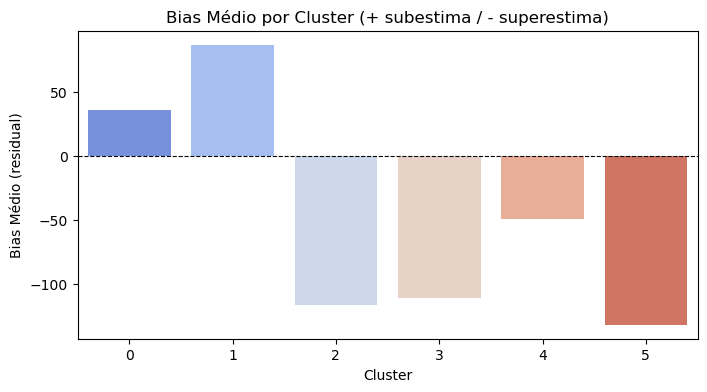

In [ ]:
# 8. VISUALIZAÇÕES
print("\n" + "="*90)
print("📊 VISUALIZAÇÕES")
print("="*90)

# 8.1 Tamanho dos clusters de erro
pdf_size = df_worst_clustered.groupBy("prediction").count().orderBy("prediction").toPandas()
plt.figure(figsize=(8, 4))
sns.barplot(data=pdf_size, x="prediction", y="count", palette="tab10")
plt.title(f"Distribuição dos Clusters de Erro (K={best_k})")
plt.xlabel("Cluster")
plt.ylabel("n_casos")
plt.tight_layout()
plt.show()

# 8.2 Erro médio por cluster
pdf_err = summary_err.toPandas()
plt.figure(figsize=(8, 4))
sns.barplot(data=pdf_err, x="prediction", y="erro_medio_abs", palette="Reds_r")
plt.title("Erro Médio Absoluto por Cluster")
plt.xlabel("Cluster")
plt.ylabel("Erro Médio Abs")
plt.tight_layout()
plt.show()

# 8.3 Bias (subestimação vs superestimação)
plt.figure(figsize=(8, 4))
sns.barplot(data=pdf_err, x="prediction", y="bias_medio", palette="coolwarm")
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title("Bias Médio por Cluster (+ subestima / - superestima)")
plt.xlabel("Cluster")
plt.ylabel("Bias Médio (residual)")
plt.show()

**Conclusão das Imagens**:

O cruzamento do volume de casos, erro absoluto e viés indica que o modelo sofre de uma falha de calibração comportamental: o Cluster 1 detém o erro mais agressivo (maior MAE), onde o modelo é excessivamente pessimista (subestima o lucro), enquanto o Cluster 5 concentra o maior volume absoluto de falhas, onde o modelo é perigosamente otimista (superestima a rentabilidade).

**Pontos principais:**

- Cluster 1 (O maior erro individual): Apresenta o maior Erro Médio Absoluto ($> 140$), indicando que este nicho de clientes possui variáveis que o LightGBM não consegue processar corretamente, resultando em uma subestimação severa.

- Cluster 5 (O erro de massa): É o grupo com o maior número de ocorrências ($n > 50.000$). O bias negativo indica que o modelo projeta lucros que não se concretizam, representando o maior risco financeiro de "falso positivo" para a operação.

- Clusters 0 e 1 vs. Clusters 2, 3 e 5: Existe uma divisão clara de "personalidade" do erro; enquanto nos clusters 0 e 1 o modelo tende a ser conservador demais (bias positivo), nos demais ele tende a ser agressivo na projeção de valor (bias negativo).

Essa estrutura sugere que o erro do LightGBM está diretamente ligado à incapacidade de diferenciar sinais contraditórios de engajamento vs. contrato, especialmente em clientes fora do regime de renovação automática.

### 14.6.4. Conclusão Final e Estratégia de Mitigação

Após a análise profunda dos resíduos e a clusterização dos erros do LightGBM, conclui-se que o modelo atual é altamente confiável para **85% da base** (especialmente clientes em regime de renovação automática), mas apresenta "pontos cegos" em nichos específicos.

**Proposta de Mitigação Imediata (Sem Retreinar o Modelo)**

Para a entrada em produção **amanhã**, a estratégia recomendada é a **Regra de Pós-Processamento**:

- Sinalização de Confiança: implementar um "flag" de baixa confiança para clientes que se enquadrem nos perfis dos Clusters 0 e 1 de erro (clientes com alta margem real, mas sem renovação automática);
- Fator de Correção (Hedge): aplicar um ajuste manual (offset) nas predições do Cluster 5. Como o modelo superestima sistematicamente esse grupo em cerca de 131 unidades, a predição final deve ser deflacionada para garantir uma visão financeira mais conservadora;
- Tratamento de Exceção: clientes com `auto_renew == 0` e `has_transactions == 1` devem passar por uma revisão de regra de negócio, pois o modelo tende a ser excessivamente otimista com o engajamento manual.

**Proposta de Longo Prazo (melhoria para a solução atual)**

O algoritmo escolhido não precisa ser alterado. Porém, os pontos focais serão:

- Aperfeiçoamento de feature engineering: criar variáveis de interação entre "Status Contratual" e "Uso Efetivo";
- **(Ideia)** Modelo de Dois Estágios: fittar um modelo classificador para identificar se o cliente é "instável" (Cluster 0) seguido de um regressor especialista para esse nicho.

**Por que não refazer agora?**

O que foi encontrado (ênfase nos Clusters 1 e 5) indica que o problema é de sinal dos dados (features que o modelo interpreta de um jeito, mas o negócio se comporta de outro). Retreinar o LightGBM hoje com as mesmas variáveis não resolveria isso; apenas mudaria o erro de lugar. Corrigir o modelo na etapa atual em que estou agora, exigiria voltar bons passos atrás e comprometeria muito tempo. Como foi mapeado que basicamente 85% das predições são plenamente confiáveis e as demais não devem ser simplesmente desconsideradas, mas somente ajustas, o modelo com algoritmo LightGBM executado até então permanece como finalista.

### 14.6.5. Salvando bases

In [ ]:
print("Salvando base que contém os maiores 5% de erros do LightGBM...")
# Perfil dos clusters de erro (somente os maiores 5% de erros)
df_worst_clustered.write.mode("overwrite").partitionBy("safra").parquet(gold_path + "df_clustered_03_worst_errors")
print("Dataset salvo em:", gold_path + "df_clustered_03_worst_errors")

# Base total (permite calcular a chance do grupo ser erro)
print("Salvando base que contém o conjunto de cliente-safra de teste e OOT, sem filtrar maiores 5% de erros do LightGBM...")
df_audit_clustered.write.mode("overwrite").partitionBy("safra").parquet(gold_path + "df_clustered_03_error_chance")
print("Dataset salvo em:", gold_path + "df_clustered_03_error_chance")

Salvando base que contém os maiores 5% de erros do LightGBM...
Dataset salvo em: C:/Users/Gustavo/Downloads/datamaster/dados/gold/df_clustered_03_worst_errors
Salvando base que contém o conjunto de cliente-safra de teste e OOT, sem filtrar maiores 5% de erros do LightGBM...
Dataset salvo em: C:/Users/Gustavo/Downloads/datamaster/dados/gold/df_clustered_03_error_chance
